
## Create Session
Below initializes a Spark session, which is the entry point for programming Spark applications. It sets up internal services and establishes a connection to a Spark execution environment.

In [1]:
# Create the Spark Session
from pyspark.sql import SparkSession

spark = (
    SparkSession 
    .builder 
    .appName("Streaming from Kafka") 
    .config("spark.streaming.stopGracefullyOnShutdown", True) 
    .config('spark.jars.packages', 'org.apache.spark:spark-sql-kafka-0-10_2.12:3.3.0')
    .config("spark.sql.shuffle.partitions", 4)
    .master("local[*]") 
    .getOrCreate()
)

spark

# Obtaining our Data
## About the Data
Our data comes from a variety of sources, all aimed at creating a full view of airport delay through various study metrics involving the airport, aircraft, airline, passengers, and weather.

Our primary dataset is the Bureau of Transportation Statistics' Montly On-Time Report, which for the year of 2019 comprises several million rows of data on every flight flown domestically for the entire year. We use and combine these monthly statistics with a variety of other data sets to gain further insights.

We use 5 informational datasets from the Bureau of Transportation Statistics:
* T3_AIR_CARRIER_SUMMARY_AIRPORT_ACTIVITY.csv
* B43_AIRCRAFT_INVENTORY.csv
* AIRPORT_COORDINATES.csv
* CARRIER_DECODE.csv
* P10_EMPLOYEES.csv


2 informational datasets from the National Centers for Environmental Information
* Airport_Weather.csv
* Airport_list.csv

The data sets can be refined at download, so I chose features that I needed when acquiring the data.

Our base data of on-time reporting is feature rich. We have detailed information for EVERY flight taken, including the date, the carrier, the tail number, the origin airport, the destination airport, the time the flight left, the reason for delay if delayed, the length of the flight, and the distance it traveled on the flight. We are interested in the delay and will clean for both general delay and specific delay.

# Cleaning our Data
T3_AIR_CARRIER_SUMMARY_AIRPORT_ACTIVITY provides information on how many departures were performed (REV_ACRFT_DEP_PERF_510) and how many passengers were enplaned (REV_PAX_ENP_110) by CARRIER and AIRPORT. We'll use this data to provide metrics for the "busy-ness" of an airport and airline.

In [2]:
# Create the kafka_df to read from kafka

kafka_df = (
    spark
    .read
    .format("kafka")
    .option("kafka.bootstrap.servers", "project1-kafka-1:9093")
    .option("subscribe", "passengers_topic")
    .option("startingOffsets", "earliest")
    .load()
)

In [3]:
# View schema for raw kafka_df
kafka_df.printSchema()
kafka_df.show()

root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)

+-------------------+--------------------+----------------+---------+------+--------------------+-------------+
|                key|               value|           topic|partition|offset|           timestamp|timestampType|
+-------------------+--------------------+----------------+---------+------+--------------------+-------------+
|[38 37 39 34 39 37]|[7B 22 4F 50 5F 5...|passengers_topic|        0|     0|2024-05-03 22:38:...|            0|
|   [32 35 32 37 33]|[7B 22 4F 50 5F 5...|passengers_topic|        0|     1|2024-05-03 22:38:...|            0|
|[39 33 37 38 32 36]|[7B 22 4F 50 5F 5...|passengers_topic|        0|     2|2024-05-03 22:38:...|            0|
|[32 33 31 30 35 33]|[7B 22 4F 50 5F 5...|pas

In [4]:
from pyspark.sql.functions import expr

kafka_json_df = kafka_df.withColumn("value", expr("cast(value as string)"))

In [5]:
kafka_json_df.show()

+-------------------+--------------------+----------------+---------+------+--------------------+-------------+
|                key|               value|           topic|partition|offset|           timestamp|timestampType|
+-------------------+--------------------+----------------+---------+------+--------------------+-------------+
|[38 37 39 34 39 37]|{"OP_UNIQUE_CARRI...|passengers_topic|        0|     0|2024-05-03 22:38:...|            0|
|   [32 35 32 37 33]|{"OP_UNIQUE_CARRI...|passengers_topic|        0|     1|2024-05-03 22:38:...|            0|
|[39 33 37 38 32 36]|{"OP_UNIQUE_CARRI...|passengers_topic|        0|     2|2024-05-03 22:38:...|            0|
|[32 33 31 30 35 33]|{"OP_UNIQUE_CARRI...|passengers_topic|        0|     3|2024-05-03 22:38:...|            0|
|[33 31 30 36 32 31]|{"OP_UNIQUE_CARRI...|passengers_topic|        0|     4|2024-05-03 22:38:...|            0|
|[37 30 35 31 39 30]|{"OP_UNIQUE_CARRI...|passengers_topic|        0|     5|2024-05-03 22:38:...|       

In [6]:
from pyspark.sql.types import StringType, StructField, StructType, DoubleType, IntegerType


# New schema definition based on provided columns
json_schema = StructType([
    StructField('OP_UNIQUE_CARRIER', StringType(), True),
    StructField('CARRIER_NAME', StringType(), True),
    StructField('ORIGIN_AIRPORT_ID', IntegerType(), True),
    StructField('SERVICE_CLASS', StringType(), True),
    StructField('REV_ACRFT_DEP_PERF_510', IntegerType(), True),
    StructField('REV_PAX_ENP_110', IntegerType(), True)
])

In [7]:
from pyspark.sql.functions import from_json,col

streaming_df = kafka_json_df.withColumn("values_json", from_json(col("value"), json_schema)).selectExpr("values_json.*")

In [8]:
streaming_df.printSchema()

root
 |-- OP_UNIQUE_CARRIER: string (nullable = true)
 |-- CARRIER_NAME: string (nullable = true)
 |-- ORIGIN_AIRPORT_ID: integer (nullable = true)
 |-- SERVICE_CLASS: string (nullable = true)
 |-- REV_ACRFT_DEP_PERF_510: integer (nullable = true)
 |-- REV_PAX_ENP_110: integer (nullable = true)



In [9]:
parsed_df = kafka_df.select(
    from_json(col("value").cast("string"), json_schema).alias("parsed_value")
)

In [10]:
# Assuming `parsed_df` is a DataFrame that has already parsed the JSON data using the new airport schema
flattened_df = parsed_df.select(
    col("parsed_value.OP_UNIQUE_CARRIER").alias("OP_UNIQUE_CARRIER"),
    col("parsed_value.CARRIER_NAME").alias("CARRIER_NAME"),
    col("parsed_value.ORIGIN_AIRPORT_ID").alias("ORIGIN_AIRPORT_ID"),
    col("parsed_value.SERVICE_CLASS").alias("SERVICE_CLASS"),
    col("parsed_value.REV_ACRFT_DEP_PERF_510").alias("REV_ACRFT_DEP_PERF_510"),
    col("parsed_value.REV_PAX_ENP_110").alias("REV_PAX_ENP_110")
)


In [11]:
flattened_df.show()

+-----------------+------------------+-----------------+-------------+----------------------+---------------+
|OP_UNIQUE_CARRIER|      CARRIER_NAME|ORIGIN_AIRPORT_ID|SERVICE_CLASS|REV_ACRFT_DEP_PERF_510|REV_PAX_ENP_110|
+-----------------+------------------+-----------------+-------------+----------------------+---------------+
|              04Q|Tradewind Aviation|            15024|            K|                  null|           null|
|              04Q|Tradewind Aviation|            14843|            K|                  null|           null|
|              04Q|Tradewind Aviation|            10257|            V|                  null|           null|
|              04Q|Tradewind Aviation|            15323|            V|                  null|           null|
|              04Q|Tradewind Aviation|            10158|            V|                  null|           null|
|              04Q|Tradewind Aviation|            10821|            V|                  null|           null|
|         

In [12]:
type(flattened_df)

pyspark.sql.dataframe.DataFrame

In [13]:
passengers = flattened_df.toPandas()
passengers.head()

,OP_UNIQUE_CARRIER,CARRIER_NAME,ORIGIN_AIRPORT_ID,SERVICE_CLASS,REV_ACRFT_DEP_PERF_510,REV_PAX_ENP_110
0,04Q,Tradewind Aviation,15024,K,NaN,NaN
1,04Q,Tradewind Aviation,14843,K,NaN,NaN
2,04Q,Tradewind Aviation,10257,V,NaN,NaN
3,04Q,Tradewind Aviation,15323,V,NaN,NaN
4,04Q,Tradewind Aviation,10158,V,NaN,NaN


In [14]:
passengers.shape

(27252, 6)

B43_AIRCRAFT_INVENTORY provides information about specific tail numbers. We want to know the age of an aircraft, and how many passengers it seats.

In [15]:
kafka_df = (
    spark
    .read
    .format("kafka")
    .option("kafka.bootstrap.servers", "project1-kafka-1:9093")
    .option("subscribe", "aircraft_topic")
    .option("startingOffsets", "earliest")
    .load()
)

In [16]:
# View schema for raw kafka_df
kafka_df.printSchema()
kafka_df.show()

root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)

+-------------------+--------------------+--------------+---------+------+--------------------+-------------+
|                key|               value|         topic|partition|offset|           timestamp|timestampType|
+-------------------+--------------------+--------------+---------+------+--------------------+-------------+
|[32 34 39 33 34 37]|[7B 22 4D 41 4E 5...|aircraft_topic|        0|     0|2024-05-03 23:03:...|            0|
|[39 38 32 39 36 38]|[7B 22 4D 41 4E 5...|aircraft_topic|        0|     1|2024-05-03 23:03:...|            0|
|[37 39 31 36 35 38]|[7B 22 4D 41 4E 5...|aircraft_topic|        0|     2|2024-05-03 23:03:...|            0|
|   [39 37 36 37 30]|[7B 22 4D 41 4E 5...|aircraft_topic|

In [17]:
from pyspark.sql.functions import expr

kafka_json_df = kafka_df.withColumn("value", expr("cast(value as string)"))
kafka_json_df.show()

+-------------------+--------------------+--------------+---------+------+--------------------+-------------+
|                key|               value|         topic|partition|offset|           timestamp|timestampType|
+-------------------+--------------------+--------------+---------+------+--------------------+-------------+
|[32 34 39 33 34 37]|{"MANUFACTURE_YEA...|aircraft_topic|        0|     0|2024-05-03 23:03:...|            0|
|[39 38 32 39 36 38]|{"MANUFACTURE_YEA...|aircraft_topic|        0|     1|2024-05-03 23:03:...|            0|
|[37 39 31 36 35 38]|{"MANUFACTURE_YEA...|aircraft_topic|        0|     2|2024-05-03 23:03:...|            0|
|   [39 37 36 37 30]|{"MANUFACTURE_YEA...|aircraft_topic|        0|     3|2024-05-03 23:03:...|            0|
|[36 36 39 32 36 34]|{"MANUFACTURE_YEA...|aircraft_topic|        0|     4|2024-05-03 23:03:...|            0|
|[37 36 33 31 34 30]|{"MANUFACTURE_YEA...|aircraft_topic|        0|     5|2024-05-03 23:03:...|            0|
|[39 36 38

In [18]:
from pyspark.sql.types import StringType, StructField, StructType, DoubleType, IntegerType


json_schema = StructType([
    StructField('MANUFACTURE_YEAR', IntegerType(), True),
    StructField('TAIL_NUM', StringType(), True),
    StructField('NUMBER_OF_SEATS', IntegerType(), True)
])

In [19]:
from pyspark.sql.functions import from_json,col

streaming_df = kafka_json_df.withColumn("values_json", from_json(col("value"), json_schema)).selectExpr("values_json.*")

In [20]:
streaming_df.printSchema()

root
 |-- MANUFACTURE_YEAR: integer (nullable = true)
 |-- TAIL_NUM: string (nullable = true)
 |-- NUMBER_OF_SEATS: integer (nullable = true)



In [21]:
parsed_df = kafka_df.select(
    from_json(col("value").cast("string"), json_schema).alias("parsed_value")
)

In [22]:
# Assuming `parsed_df` is a DataFrame that has already parsed the JSON data using the new airport schema
flattened_df = parsed_df.select(
    col("parsed_value.MANUFACTURE_YEAR").alias("MANUFACTURE_YEAR"),
    col("parsed_value.TAIL_NUM").alias("TAIL_NUM"),
    col("parsed_value.NUMBER_OF_SEATS").alias("NUMBER_OF_SEATS")
)
flattened_df.show()

+----------------+--------+---------------+
|MANUFACTURE_YEAR|TAIL_NUM|NUMBER_OF_SEATS|
+----------------+--------+---------------+
|            1944|  N54514|           null|
|            1945|  N1651M|           null|
|            1953|  N100CE|           null|
|            1953|  N141FL|           null|
|            1953|  N151FL|           null|
|            1953|  N381FL|           null|
|            1954|  N6174C|           null|
|            1954|  N400UA|           null|
|            1955|  N747CE|           null|
|            1955|  N9148F|           null|
|            1955|  N131FL|           null|
|            1955|  N351FL|           null|
|            1955|  N391FL|           null|
|            1956|  N171FL|           null|
|            1956|  N181FL|           null|
|            1956|  N191FL|           null|
|            1956|  N361FL|           null|
|            1956|  N371FL|           null|
|            1957|  N551CE|           null|
|            1957|  N555SQ|     

In [23]:
aircraft= flattened_df.toPandas()
aircraft

,MANUFACTURE_YEAR,TAIL_NUM,NUMBER_OF_SEATS
0,1944,N54514,NaN
1,1945,N1651M,NaN
2,1953,N100CE,NaN
3,1953,N141FL,NaN
4,1953,N151FL,NaN
...,...,...,...
7378,2019,N14011,NaN
7379,2019,N16008,NaN
7380,2019,N16009,NaN
7381,2019,N2250U,NaN


In [24]:
aircraft.drop_duplicates(subset='TAIL_NUM', inplace=True)
aircraft

,MANUFACTURE_YEAR,TAIL_NUM,NUMBER_OF_SEATS
0,1944,N54514,NaN
1,1945,N1651M,NaN
2,1953,N100CE,NaN
3,1953,N141FL,NaN
4,1953,N151FL,NaN
...,...,...,...
7378,2019,N14011,NaN
7379,2019,N16008,NaN
7380,2019,N16009,NaN
7381,2019,N2250U,NaN


In [25]:
kafka_df = (
    spark
    .read
    .format("kafka")
    .option("kafka.bootstrap.servers", "project1-kafka-1:9093")
    .option("subscribe", "employees")
    .option("startingOffsets", "earliest")
    .load()
)

In [26]:
# View schema for raw kafka_df
kafka_df.printSchema()
kafka_df.show()

from pyspark.sql.functions import expr

kafka_json_df = kafka_df.withColumn("value", expr("cast(value as string)"))
kafka_json_df.show()

from pyspark.sql.types import StringType, StructField, StructType, DoubleType, IntegerType


json_schema = StructType([
    StructField('YEAR', IntegerType(), True),
    StructField('AIRLINE_ID', IntegerType(), True),
    StructField('OP_UNIQUE_CARRIER', StringType(), True),
    StructField('UNIQUE_CARRIER_NAME', StringType(), True),
    StructField('CARRIER', StringType(), True),
    StructField('CARRIER_NAME', StringType(), True),
    StructField('ENTITY', StringType(), True),
    StructField('GENERAL_MANAGE', IntegerType(), True),
    StructField('PILOTS_COPILOTS', IntegerType(), True),
    StructField('OTHER_FLT_PERS', IntegerType(), True),
    StructField('PASS_GEN_SVC_ADMIN', IntegerType(), True),
    StructField('MAINTENANCE', IntegerType(), True),
    StructField('ARCFT_TRAF_HANDLING_GRP1', IntegerType(), True),
    StructField('GEN_ARCFT_TRAF_HANDLING', IntegerType(), True),
    StructField('AIRCRAFT_CONTROL', IntegerType(), True),
    StructField('PASSENGER_HANDLING', IntegerType(), True),
    StructField('CARGO_HANDLING', IntegerType(), True),
    StructField('TRAINEES_INTRUCTOR', IntegerType(), True),
    StructField('STATISTICAL', IntegerType(), True),
    StructField('TRAFFIC_SOLICITERS', IntegerType(), True),
    StructField('OTHER', IntegerType(), True),
    StructField('TRANSPORT_RELATED', IntegerType(), True),
    StructField('TOTAL', IntegerType(), True)
])

from pyspark.sql.functions import from_json,col

streaming_df = kafka_json_df.withColumn("values_json", from_json(col("value"), json_schema)).selectExpr("values_json.*")
parsed_df = kafka_df.select(
    from_json(col("value").cast("string"), json_schema).alias("parsed_value")
)

# Assuming `parsed_df` is a DataFrame that has already parsed the JSON data using the new airport schema
flattened_df = parsed_df.select(
    col("parsed_value.YEAR").alias("YEAR"),
    col("parsed_value.AIRLINE_ID").alias("AIRLINE_ID"),
    col("parsed_value.OP_UNIQUE_CARRIER").alias("OP_UNIQUE_CARRIER"),
    col("parsed_value.UNIQUE_CARRIER_NAME").alias("UNIQUE_CARRIER_NAME"),
    col("parsed_value.CARRIER").alias("CARRIER"),
    col("parsed_value.CARRIER_NAME").alias("CARRIER_NAME"),
    col("parsed_value.ENTITY").alias("ENTITY"),
    col("parsed_value.GENERAL_MANAGE").alias("GENERAL_MANAGE"),
    col("parsed_value.PILOTS_COPILOTS").alias("PILOTS_COPILOTS"),
    col("parsed_value.OTHER_FLT_PERS").alias("OTHER_FLT_PERS"),
    col("parsed_value.PASS_GEN_SVC_ADMIN").alias("PASS_GEN_SVC_ADMIN"),
    col("parsed_value.MAINTENANCE").alias("MAINTENANCE"),
    col("parsed_value.ARCFT_TRAF_HANDLING_GRP1").alias("ARCFT_TRAF_HANDLING_GRP1"),
    col("parsed_value.GEN_ARCFT_TRAF_HANDLING").alias("GEN_ARCFT_TRAF_HANDLING"),
    col("parsed_value.AIRCRAFT_CONTROL").alias("AIRCRAFT_CONTROL"),
    col("parsed_value.PASSENGER_HANDLING").alias("PASSENGER_HANDLING"),
    col("parsed_value.CARGO_HANDLING").alias("CARGO_HANDLING"),
    col("parsed_value.TRAINEES_INTRUCTOR").alias("TRAINEES_INTRUCTOR"),
    col("parsed_value.STATISTICAL").alias("STATISTICAL"),
    col("parsed_value.TRAFFIC_SOLICITERS").alias("TRAFFIC_SOLICITERS"),
    col("parsed_value.OTHER").alias("OTHER"),
    col("parsed_value.TRANSPORT_RELATED").alias("TRANSPORT_RELATED"),
    col("parsed_value.TOTAL").alias("TOTAL")
)
flattened_df.show()

root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)

+-------------------+--------------------+---------+---------+------+--------------------+-------------+
|                key|               value|    topic|partition|offset|           timestamp|timestampType|
+-------------------+--------------------+---------+---------+------+--------------------+-------------+
|[37 38 36 34 38 33]|[7B 22 59 45 41 5...|employees|        0|     0|2024-05-03 23:14:...|            0|
|[34 37 38 30 38 37]|[7B 22 59 45 41 5...|employees|        0|     1|2024-05-03 23:14:...|            0|
|[38 30 38 32 36 30]|[7B 22 59 45 41 5...|employees|        0|     2|2024-05-03 23:14:...|            0|
|[35 30 38 36 39 33]|[7B 22 59 45 41 5...|employees|        0|     3|2024-05-03 23:14:.

In [27]:
employees= flattened_df.toPandas() 
employees = employees[['OP_UNIQUE_CARRIER', 'PASS_GEN_SVC_ADMIN', 'PASSENGER_HANDLING']]
employees = employees.groupby('OP_UNIQUE_CARRIER').sum().reset_index()
employees

,OP_UNIQUE_CARRIER,PASS_GEN_SVC_ADMIN,PASSENGER_HANDLING
0,0WQ,19,0
1,1BQ,41,0
2,2HQ,24,0
3,3EQ,32,0
4,5V,0,0
5,5X,0,0
6,5Y,273,0
7,8C,37,0
8,9E,1361,0
9,9S,3,0


In [28]:
kafka_df = (
    spark
    .read
    .format("kafka")
    .option("kafka.bootstrap.servers", "project1-kafka-1:9093")
    .option("subscribe", "employees")
    .option("startingOffsets", "earliest")
    .load()
)

In [29]:
# View schema for raw kafka_df
kafka_df.printSchema()
kafka_df.show()

from pyspark.sql.functions import expr

kafka_json_df = kafka_df.withColumn("value", expr("cast(value as string)"))
kafka_json_df.show()

from pyspark.sql.types import StringType, StructField, StructType, DoubleType, IntegerType


json_schema = StructType([
    StructField('YEAR', IntegerType(), True),
    StructField('AIRLINE_ID', IntegerType(), True),
    StructField('OP_UNIQUE_CARRIER', StringType(), True),
    StructField('UNIQUE_CARRIER_NAME', StringType(), True),
    StructField('CARRIER', StringType(), True),
    StructField('CARRIER_NAME', StringType(), True),
    StructField('ENTITY', StringType(), True),
    StructField('GENERAL_MANAGE', IntegerType(), True),
    StructField('PILOTS_COPILOTS', IntegerType(), True),
    StructField('OTHER_FLT_PERS', IntegerType(), True),
    StructField('PASS_GEN_SVC_ADMIN', IntegerType(), True),
    StructField('MAINTENANCE', IntegerType(), True),
    StructField('ARCFT_TRAF_HANDLING_GRP1', IntegerType(), True),
    StructField('GEN_ARCFT_TRAF_HANDLING', IntegerType(), True),
    StructField('AIRCRAFT_CONTROL', IntegerType(), True),
    StructField('PASSENGER_HANDLING', IntegerType(), True),
    StructField('CARGO_HANDLING', IntegerType(), True),
    StructField('TRAINEES_INTRUCTOR', IntegerType(), True),
    StructField('STATISTICAL', IntegerType(), True),
    StructField('TRAFFIC_SOLICITERS', IntegerType(), True),
    StructField('OTHER', IntegerType(), True),
    StructField('TRANSPORT_RELATED', IntegerType(), True),
    StructField('TOTAL', IntegerType(), True)
])

from pyspark.sql.functions import from_json,col

streaming_df = kafka_json_df.withColumn("values_json", from_json(col("value"), json_schema)).selectExpr("values_json.*")
parsed_df = kafka_df.select(
    from_json(col("value").cast("string"), json_schema).alias("parsed_value")
)

# Assuming `parsed_df` is a DataFrame that has already parsed the JSON data using the new airport schema
flattened_df = parsed_df.select(
    col("parsed_value.YEAR").alias("YEAR"),
    col("parsed_value.AIRLINE_ID").alias("AIRLINE_ID"),
    col("parsed_value.OP_UNIQUE_CARRIER").alias("OP_UNIQUE_CARRIER"),
    col("parsed_value.UNIQUE_CARRIER_NAME").alias("UNIQUE_CARRIER_NAME"),
    col("parsed_value.CARRIER").alias("CARRIER"),
    col("parsed_value.CARRIER_NAME").alias("CARRIER_NAME"),
    col("parsed_value.ENTITY").alias("ENTITY"),
    col("parsed_value.GENERAL_MANAGE").alias("GENERAL_MANAGE"),
    col("parsed_value.PILOTS_COPILOTS").alias("PILOTS_COPILOTS"),
    col("parsed_value.OTHER_FLT_PERS").alias("OTHER_FLT_PERS"),
    col("parsed_value.PASS_GEN_SVC_ADMIN").alias("PASS_GEN_SVC_ADMIN"),
    col("parsed_value.MAINTENANCE").alias("MAINTENANCE"),
    col("parsed_value.ARCFT_TRAF_HANDLING_GRP1").alias("ARCFT_TRAF_HANDLING_GRP1"),
    col("parsed_value.GEN_ARCFT_TRAF_HANDLING").alias("GEN_ARCFT_TRAF_HANDLING"),
    col("parsed_value.AIRCRAFT_CONTROL").alias("AIRCRAFT_CONTROL"),
    col("parsed_value.PASSENGER_HANDLING").alias("PASSENGER_HANDLING"),
    col("parsed_value.CARGO_HANDLING").alias("CARGO_HANDLING"),
    col("parsed_value.TRAINEES_INTRUCTOR").alias("TRAINEES_INTRUCTOR"),
    col("parsed_value.STATISTICAL").alias("STATISTICAL"),
    col("parsed_value.TRAFFIC_SOLICITERS").alias("TRAFFIC_SOLICITERS"),
    col("parsed_value.OTHER").alias("OTHER"),
    col("parsed_value.TRANSPORT_RELATED").alias("TRANSPORT_RELATED"),
    col("parsed_value.TOTAL").alias("TOTAL")
)
flattened_df.show()

root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)

+-------------------+--------------------+---------+---------+------+--------------------+-------------+
|                key|               value|    topic|partition|offset|           timestamp|timestampType|
+-------------------+--------------------+---------+---------+------+--------------------+-------------+
|[37 38 36 34 38 33]|[7B 22 59 45 41 5...|employees|        0|     0|2024-05-03 23:14:...|            0|
|[34 37 38 30 38 37]|[7B 22 59 45 41 5...|employees|        0|     1|2024-05-03 23:14:...|            0|
|[38 30 38 32 36 30]|[7B 22 59 45 41 5...|employees|        0|     2|2024-05-03 23:14:...|            0|
|[35 30 38 36 39 33]|[7B 22 59 45 41 5...|employees|        0|     3|2024-05-03 23:14:.

In [30]:
employees= flattened_df.toPandas() 
employees = employees[['OP_UNIQUE_CARRIER', 'PASS_GEN_SVC_ADMIN', 'PASSENGER_HANDLING']]
employees = employees.groupby('OP_UNIQUE_CARRIER').sum().reset_index()
employees

,OP_UNIQUE_CARRIER,PASS_GEN_SVC_ADMIN,PASSENGER_HANDLING
0,0WQ,19,0
1,1BQ,41,0
2,2HQ,24,0
3,3EQ,32,0
4,5V,0,0
5,5X,0,0
6,5Y,273,0
7,8C,37,0
8,9E,1361,0
9,9S,3,0


In [31]:
kafka_df = (
    spark
    .read
    .format("kafka")
    .option("kafka.bootstrap.servers", "project1-kafka-1:9093")
    .option("subscribe", "names_topic")
    .option("startingOffsets", "earliest")
    .load()
)

In [32]:
# View schema for raw kafka_df
kafka_df.printSchema()
kafka_df.show()

from pyspark.sql.functions import expr

kafka_json_df = kafka_df.withColumn("value", expr("cast(value as string)"))
kafka_json_df.show()

from pyspark.sql.types import StringType, StructField, StructType, DoubleType, IntegerType


json_schema = StructType([
    StructField('AIRLINE_ID', IntegerType(), True),
    StructField('OP_UNIQUE_CARRIER', StringType(), True),
    StructField('CARRIER_NAME', StringType(), True)
])

from pyspark.sql.functions import from_json,col

streaming_df = kafka_json_df.withColumn("values_json", from_json(col("value"), json_schema)).selectExpr("values_json.*")
parsed_df = kafka_df.select(
    from_json(col("value").cast("string"), json_schema).alias("parsed_value")
)

# Assuming `parsed_df` is a DataFrame that has already parsed the JSON data using the new airport schema
flattened_df = parsed_df.select(
    col("parsed_value.OP_UNIQUE_CARRIER").alias("OP_UNIQUE_CARRIER"),
    col("parsed_value.CARRIER_NAME").alias("CARRIER_NAME"),
    col("parsed_value.AIRLINE_ID").alias("AIRLINE_ID")
)
flattened_df.show()

root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)

+-------------------+--------------------+-----------+---------+------+--------------------+-------------+
|                key|               value|      topic|partition|offset|           timestamp|timestampType|
+-------------------+--------------------+-----------+---------+------+--------------------+-------------+
|[38 34 39 38 36 39]|[7B 22 4F 50 5F 5...|names_topic|        0|     0|2024-05-04 02:28:...|            0|
|   [35 32 38 37 35]|[7B 22 4F 50 5F 5...|names_topic|        0|     1|2024-05-04 02:28:...|            0|
|[39 37 37 38 36 32]|[7B 22 4F 50 5F 5...|names_topic|        0|     2|2024-05-04 02:28:...|            0|
|[37 35 39 31 30 36]|[7B 22 4F 50 5F 5...|names_topic|        0|     3|2024

In [33]:
names= flattened_df.toPandas() 
names.drop_duplicates(inplace=True)
names.drop_duplicates(subset=['OP_UNIQUE_CARRIER'], inplace=True)
names

,OP_UNIQUE_CARRIER,CARRIER_NAME,AIRLINE_ID
0,2PQ,21 Air LLC,21754
3,Q5,40-Mile Air,20342
4,WRB,40-Mile Air,20342
6,CIQ,A/S Conair,19627
7,AAE,AAA Airlines,19072
...,...,...,...
2702,ZKQ,Zantop International,20379
2706,ZAQ,Zas Airline Of Egypt,19771
2707,37,Zeal 320,21118
2708,ZG,ZIPAIR Tokyo Inc.,22069


In [34]:
kafka_df = (
    spark
    .read
    .format("kafka")
    .option("kafka.bootstrap.servers", "project1-kafka-1:9093")
    .option("subscribe", "coords_topic")
    .option("startingOffsets", "earliest")
    .load()
)

In [35]:
# View schema for raw kafka_df
kafka_df.printSchema()
kafka_df.show()

from pyspark.sql.functions import expr

kafka_json_df = kafka_df.withColumn("value", expr("cast(value as string)"))
kafka_json_df.show()

from pyspark.sql.types import StringType, StructField, StructType, DoubleType, IntegerType


json_schema = StructType([
    StructField('ORIGIN_AIRPORT_ID', IntegerType(), True),
    StructField('DISPLAY_AIRPORT_NAME', StringType(), True),
    StructField('LATITUDE', DoubleType(), True),
    StructField('LONGITUDE', DoubleType(), True)
])

from pyspark.sql.functions import from_json,col

streaming_df = kafka_json_df.withColumn("values_json", from_json(col("value"), json_schema)).selectExpr("values_json.*")
parsed_df = kafka_df.select(
    from_json(col("value").cast("string"), json_schema).alias("parsed_value")
)

# Assuming `parsed_df` is a DataFrame that has already parsed the JSON data using the new airport schema
flattened_df = parsed_df.select(
    col("parsed_value.ORIGIN_AIRPORT_ID").alias("ORIGIN_AIRPORT_ID"),
    col("parsed_value.DISPLAY_AIRPORT_NAME").alias("DISPLAY_AIRPORT_NAME"),
    col("parsed_value.LATITUDE").alias("LATITUDE"),
    col("parsed_value.LONGITUDE").alias("LONGITUDE")
)
flattened_df.show()

root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)

+-------------------+--------------------+------------+---------+------+--------------------+-------------+
|                key|               value|       topic|partition|offset|           timestamp|timestampType|
+-------------------+--------------------+------------+---------+------+--------------------+-------------+
|[34 39 31 34 30 37]|[7B 22 4F 52 49 4...|coords_topic|        0|     0|2024-05-04 02:38:...|            0|
|[38 35 34 36 30 36]|[7B 22 4F 52 49 4...|coords_topic|        0|     1|2024-05-04 02:38:...|            0|
|[38 34 35 31 37 38]|[7B 22 4F 52 49 4...|coords_topic|        0|     2|2024-05-04 02:38:...|            0|
|   [39 35 30 30 32]|[7B 22 4F 52 49 4...|coords_topic|        0|    

In [36]:
coords= flattened_df.toPandas()                         
coords.drop_duplicates(subset='ORIGIN_AIRPORT_ID', inplace=True)
coords

,ORIGIN_AIRPORT_ID,DISPLAY_AIRPORT_NAME,LATITUDE,LONGITUDE
0,10001,Afognak Lake Airport,58.109444,-152.906667
1,10003,Bear Creek Mining Strip,65.548056,-161.071667
2,10004,Lik Mining Camp,68.083333,-163.166667
3,10005,Little Squaw Airport,67.570000,-148.183889
4,10006,Kizhuyak Bay,57.745278,-152.882778
...,...,...,...,...
18128,16908,Deer Park Airport,47.966944,-117.428611
18129,16909,South Texas International at Edinburg,26.441667,-98.122222
18130,16910,Louisa County Freeman Field,38.009722,-77.970000
18131,16911,Caldwell Industrial,43.641944,-116.635833


In [37]:
kafka_df = (
    spark
    .read
    .format("kafka")
    .option("kafka.bootstrap.servers", "project1-kafka-1:9093")
    .option("subscribe", "weather_topic")
    .option("startingOffsets", "earliest")
    .load()
)

In [38]:
# View schema for raw kafka_df
kafka_df.printSchema()
kafka_df.show()

from pyspark.sql.functions import expr

kafka_json_df = kafka_df.withColumn("value", expr("cast(value as string)"))
kafka_json_df.show()

from pyspark.sql.types import StringType, StructField, StructType, DoubleType, IntegerType


json_schema = StructType([
    StructField('STATION', StringType(), True),
    StructField('NAME', StringType(), True),
    StructField('DATE', StringType(), True),
    StructField('AWND', DoubleType(), True),
    StructField('PGTM', DoubleType(), True),
    StructField('PRCP', DoubleType(), True),
    StructField('SNOW', DoubleType(), True),
    StructField('SNWD', DoubleType(), True),
    StructField('TAVG', DoubleType(), True),
    StructField('TMAX', DoubleType(), True),
    StructField('TMIN', DoubleType(), True),
    StructField('WDF2', DoubleType(), True),
    StructField('WDF5', DoubleType(), True),
    StructField('WSF2', DoubleType(), True),
    StructField('WSF5', DoubleType(), True),
    StructField('WT01', DoubleType(), True),
    StructField('WT02', DoubleType(), True),
    StructField('WT03', DoubleType(), True),
    StructField('WT04', DoubleType(), True),
    StructField('WT05', DoubleType(), True),
    StructField('WT06', DoubleType(), True),
    StructField('WT07', DoubleType(), True),
    StructField('WT08', DoubleType(), True),
    StructField('WT09', DoubleType(), True),
    StructField('WESD', DoubleType(), True),
    StructField('WT10', DoubleType(), True),
    StructField('PSUN', DoubleType(), True),
    StructField('TSUN', DoubleType(), True),
    StructField('SN32', DoubleType(), True),
    StructField('SX32', DoubleType(), True),
    StructField('TOBS', DoubleType(), True),
    StructField('WT11', DoubleType(), True)
])

from pyspark.sql.functions import from_json,col

streaming_df = kafka_json_df.withColumn("values_json", from_json(col("value"), json_schema)).selectExpr("values_json.*")
parsed_df = kafka_df.select(
    from_json(col("value").cast("string"), json_schema).alias("parsed_value")
)

# Assuming `parsed_df` is a DataFrame that has already parsed the JSON data using the new airport schema
flattened_df = parsed_df.select(
    col("parsed_value.STATION").alias("STATION"),
    col("parsed_value.NAME").alias("NAME"),
    col("parsed_value.DATE").alias("DATE"),
    col("parsed_value.AWND").alias("AWND"),
    col("parsed_value.PGTM").alias("PGTM"),
    col("parsed_value.PRCP").alias("PRCP"),
    col("parsed_value.SNOW").alias("SNOW"),
    col("parsed_value.SNWD").alias("SNWD"),
    col("parsed_value.TAVG").alias("TAVG"),
    col("parsed_value.TMAX").alias("TMAX"),
    col("parsed_value.TMIN").alias("TMIN"),
    col("parsed_value.WDF2").alias("WDF2"),
    col("parsed_value.WDF5").alias("WDF5"),
    col("parsed_value.WSF2").alias("WSF2"),
    col("parsed_value.WSF5").alias("WSF5"),
    col("parsed_value.WT01").alias("WT01"),
    col("parsed_value.WT02").alias("WT02"),
    col("parsed_value.WT03").alias("WT03"),
    col("parsed_value.WT04").alias("WT04"),
    col("parsed_value.WT05").alias("WT05"),
    col("parsed_value.WT06").alias("WT06"),
    col("parsed_value.WT07").alias("WT07"),
    col("parsed_value.WT08").alias("WT08"),
    col("parsed_value.WT09").alias("WT09"),
    col("parsed_value.WESD").alias("WESD"),
    col("parsed_value.WT10").alias("WT10"),
    col("parsed_value.PSUN").alias("PSUN"),
    col("parsed_value.TSUN").alias("TSUN"),
    col("parsed_value.SN32").alias("SN32"),
    col("parsed_value.SX32").alias("SX32"),
    col("parsed_value.TOBS").alias("TOBS"),
    col("parsed_value.WT11").alias("WT11")
)

flattened_df.show()

root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)

+-------------------+--------------------+-------------+---------+------+--------------------+-------------+
|                key|               value|        topic|partition|offset|           timestamp|timestampType|
+-------------------+--------------------+-------------+---------+------+--------------------+-------------+
|[34 33 31 33 38 38]|[7B 22 53 54 41 5...|weather_topic|        0|     0|2024-05-04 02:46:...|            0|
|[36 30 36 36 34 31]|[7B 22 53 54 41 5...|weather_topic|        0|     1|2024-05-04 02:46:...|            0|
|[38 31 32 38 39 37]|[7B 22 53 54 41 5...|weather_topic|        0|     2|2024-05-04 02:46:...|            0|
|[39 32 36 37 30 38]|[7B 22 53 54 41 5...|weather_topic|       

In [39]:
weather_report= flattened_df.toPandas()
weather_report

,STATION,NAME,DATE,AWND,PGTM,PRCP,SNOW,SNWD,TAVG,TMAX,...,WT08,WT09,WESD,WT10,PSUN,TSUN,SN32,SX32,TOBS,WT11
0,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,1/1/2019,4.70,NaN,0.14,0.0,0.0,64.0,66.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,1/2/2019,4.92,NaN,0.57,0.0,0.0,56.0,59.0,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,1/3/2019,5.37,NaN,0.15,0.0,0.0,52.0,55.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,1/4/2019,12.08,NaN,1.44,0.0,0.0,56.0,66.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,1/5/2019,13.42,NaN,0.00,0.0,0.0,49.0,59.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38670,USW00093805,"TALLAHASSEE REGIONAL AIRPORT, FL US",2019-12-27,6.04,NaN,0.00,NaN,NaN,68.0,80.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38671,USW00093805,"TALLAHASSEE REGIONAL AIRPORT, FL US",2019-12-28,5.37,NaN,0.06,NaN,NaN,69.0,74.0,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38672,USW00093805,"TALLAHASSEE REGIONAL AIRPORT, FL US",2019-12-29,7.61,NaN,0.10,NaN,NaN,70.0,74.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38673,USW00093805,"TALLAHASSEE REGIONAL AIRPORT, FL US",2019-12-30,5.82,NaN,0.02,NaN,NaN,68.0,72.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
kafka_df = (
    spark
    .read
    .format("kafka")
    .option("kafka.bootstrap.servers", "project1-kafka-1:9093")
    .option("subscribe", "cities_topic")
    .option("startingOffsets", "earliest")
    .load()
)

In [41]:
# View schema for raw kafka_df
kafka_df.printSchema()
kafka_df.show()

from pyspark.sql.functions import expr

kafka_json_df = kafka_df.withColumn("value", expr("cast(value as string)"))
kafka_json_df.show()

from pyspark.sql.types import StringType, StructField, StructType, DoubleType, IntegerType


json_schema = StructType([
    StructField('ORIGIN_AIRPORT_ID', StringType(), True),
    StructField('DISPLAY_AIRPORT_NAME', StringType(), True),
    StructField('ORIGIN_CITY_NAME', StringType(), True),
    StructField('NAME', StringType(), True)
])

from pyspark.sql.functions import from_json,col

streaming_df = kafka_json_df.withColumn("values_json", from_json(col("value"), json_schema)).selectExpr("values_json.*")
parsed_df = kafka_df.select(
    from_json(col("value").cast("string"), json_schema).alias("parsed_value")
)

# Assuming `parsed_df` is a DataFrame that has already parsed the JSON data using the new airport schema
flattened_df = parsed_df.select(
    col("parsed_value.ORIGIN_AIRPORT_ID").alias("ORIGIN_AIRPORT_ID"),
    col("parsed_value.DISPLAY_AIRPORT_NAME").alias("DISPLAY_AIRPORT_NAME"),
    col("parsed_value.ORIGIN_CITY_NAME").alias("ORIGIN_CITY_NAME"),
    col("parsed_value.NAME").alias("NAME")
)
flattened_df.show()

root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)

+-------------------+--------------------+------------+---------+------+--------------------+-------------+
|                key|               value|       topic|partition|offset|           timestamp|timestampType|
+-------------------+--------------------+------------+---------+------+--------------------+-------------+
|[34 36 30 32 38 35]|[7B 22 4F 52 49 4...|cities_topic|        0|     0|2024-05-04 02:54:...|            0|
|[35 33 33 32 36 34]|[7B 22 4F 52 49 4...|cities_topic|        0|     1|2024-05-04 02:54:...|            0|
|[32 34 37 39 30 36]|[7B 22 4F 52 49 4...|cities_topic|        0|     2|2024-05-04 02:54:...|            0|
|[31 31 32 31 31 34]|[7B 22 4F 52 49 4...|cities_topic|        0|    

In [42]:
cities= flattened_df.toPandas()
cities

,ORIGIN_AIRPORT_ID,DISPLAY_AIRPORT_NAME,ORIGIN_CITY_NAME,NAME
0,12992,Adams Field,"Little Rock, AR","NORTH LITTLE ROCK AIRPORT, AR US"
1,10257,Albany International,"Albany, NY","ALBANY INTERNATIONAL AIRPORT, NY US"
2,10140,Albuquerque International Sunport,"Albuquerque, NM","ALBUQUERQUE INTERNATIONAL AIRPORT, NM US"
3,10299,Anchorage International,"Anchorage, AK","ANCHORAGE TED STEVENS INTERNATIONAL AIRPORT, A..."
4,10397,Atlanta Municipal,"Atlanta, GA",ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...
...,...,...,...,...
92,15370,Tulsa International,"Tulsa, OK","OKLAHOMA CITY WILL ROGERS WORLD AIRPORT, OK US"
93,12264,Washington Dulles International,"Washington, DC","WASHINGTON DULLES INTERNATIONAL AIRPORT, VA US"
94,13851,Will Rogers World,"Oklahoma City, OK","OKLAHOMA CITY WILL ROGERS WORLD AIRPORT, OK US"
95,12191,William P Hobby,"Houston, TX","HOUSTON WILLIAM P HOBBY AIRPORT, TX US"


In [43]:
# Connect our weather report with the city names
import pandas as pd
weather_merge = pd.merge(cities, weather_report, how='left', on='NAME')
weather_merge

,ORIGIN_AIRPORT_ID,DISPLAY_AIRPORT_NAME,ORIGIN_CITY_NAME,NAME,STATION,DATE,AWND,PGTM,PRCP,SNOW,...,WT08,WT09,WESD,WT10,PSUN,TSUN,SN32,SX32,TOBS,WT11
0,12992,Adams Field,"Little Rock, AR","NORTH LITTLE ROCK AIRPORT, AR US",USW00003952,2019-01-01,4.70,NaN,0.00,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,12992,Adams Field,"Little Rock, AR","NORTH LITTLE ROCK AIRPORT, AR US",USW00003952,2019-01-02,2.01,NaN,0.39,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12992,Adams Field,"Little Rock, AR","NORTH LITTLE ROCK AIRPORT, AR US",USW00003952,2019-01-03,6.26,NaN,0.44,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,12992,Adams Field,"Little Rock, AR","NORTH LITTLE ROCK AIRPORT, AR US",USW00003952,2019-01-04,2.01,NaN,0.13,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,12992,Adams Field,"Little Rock, AR","NORTH LITTLE ROCK AIRPORT, AR US",USW00003952,2019-01-05,1.79,NaN,0.00,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35020,10713,Boise Air Terminal,"Boise, ID","BOISE AIR TERMINAL, ID US",USW00024131,2019-12-27,5.82,NaN,0.00,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35021,10713,Boise Air Terminal,"Boise, ID","BOISE AIR TERMINAL, ID US",USW00024131,2019-12-28,2.24,NaN,0.00,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35022,10713,Boise Air Terminal,"Boise, ID","BOISE AIR TERMINAL, ID US",USW00024131,2019-12-29,6.26,NaN,0.04,0.1,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35023,10713,Boise Air Terminal,"Boise, ID","BOISE AIR TERMINAL, ID US",USW00024131,2019-12-30,2.46,NaN,0.00,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Cleaning Weather Data
Weather Data was acquired on a daily basis for each airport used in the data set. We will ultimately use snowfall, ground snow, precipitation, wind speed, and temperature as features in our data set.

In [44]:
# Get just the important metrics from the weather report (date, precipitation, snow, temp, wind)
weather = weather_merge[['DATE', 'PRCP', 'SNOW', 'SNWD', 'TMAX', 'AWND', 'ORIGIN_AIRPORT_ID']]
weather

,DATE,PRCP,SNOW,SNWD,TMAX,AWND,ORIGIN_AIRPORT_ID
0,2019-01-01,0.00,0.0,0.0,45.0,4.70,12992
1,2019-01-02,0.39,0.0,0.0,39.0,2.01,12992
2,2019-01-03,0.44,0.0,0.0,41.0,6.26,12992
3,2019-01-04,0.13,0.0,0.0,47.0,2.01,12992
4,2019-01-05,0.00,0.0,0.0,62.0,1.79,12992
...,...,...,...,...,...,...,...
35020,2019-12-27,0.00,0.0,0.0,35.0,5.82,10713
35021,2019-12-28,0.00,0.0,0.0,39.0,2.24,10713
35022,2019-12-29,0.04,0.1,0.0,32.0,6.26,10713
35023,2019-12-30,0.00,0.0,0.0,34.0,2.46,10713


In [45]:
# Drop any rows where no weather was recorded
weather.drop(weather.loc[weather['ORIGIN_AIRPORT_ID'].isna()].index, axis=0, inplace=True)
weather

/tmp/ipykernel_2421/1398554023.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather.drop(weather.loc[weather['ORIGIN_AIRPORT_ID'].isna()].index, axis=0, inplace=True)


,DATE,PRCP,SNOW,SNWD,TMAX,AWND,ORIGIN_AIRPORT_ID
0,2019-01-01,0.00,0.0,0.0,45.0,4.70,12992
1,2019-01-02,0.39,0.0,0.0,39.0,2.01,12992
2,2019-01-03,0.44,0.0,0.0,41.0,6.26,12992
3,2019-01-04,0.13,0.0,0.0,47.0,2.01,12992
4,2019-01-05,0.00,0.0,0.0,62.0,1.79,12992
...,...,...,...,...,...,...,...
35020,2019-12-27,0.00,0.0,0.0,35.0,5.82,10713
35021,2019-12-28,0.00,0.0,0.0,39.0,2.24,10713
35022,2019-12-29,0.04,0.1,0.0,32.0,6.26,10713
35023,2019-12-30,0.00,0.0,0.0,34.0,2.46,10713


In [46]:
# Look for null values in temperature
weather.loc[weather['TMAX'].isna()]

,DATE,PRCP,SNOW,SNWD,TMAX,AWND,ORIGIN_AIRPORT_ID
4786,2/11/2019,0.22,NaN,0.0,NaN,9.62,11298
19976,2019-10-06,0.00,NaN,0.0,NaN,12.30,15919
24068,12/23/2019,0.00,NaN,NaN,NaN,1.57,11066
24807,NaN,NaN,NaN,NaN,NaN,NaN,14843
30085,6/19/2019,NaN,NaN,0.0,NaN,7.61,14635
31953,8/1/2019,0.66,0.0,0.0,NaN,7.61,15304


In [47]:
# Impute mean in nan rows for temp and wind
weather['TMAX'].fillna(round(weather.groupby('ORIGIN_AIRPORT_ID')['TMAX'].transform('mean'), 1), inplace=True)
weather['AWND'].fillna(round(weather.groupby('ORIGIN_AIRPORT_ID')['AWND'].transform('mean'), 1), inplace=True)
weather.fillna(0, inplace=True)

/tmp/ipykernel_2421/3687021643.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather['TMAX'].fillna(round(weather.groupby('ORIGIN_AIRPORT_ID')['TMAX'].transform('mean'), 1), inplace=True)
/tmp/ipykernel_2421/3687021643.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather['AWND'].fillna(round(weather.groupby('ORIGIN_AIRPORT_ID')['AWND'].transform('mean'), 1), inplace=True)
/tmp/ipykernel_2421/3687021643.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

In [48]:
# Check no NaN remain
weather.isna().sum()

DATE                 0
PRCP                 0
SNOW                 0
SNWD                 0
TMAX                 0
AWND                 0
ORIGIN_AIRPORT_ID    0
dtype: int64

In [49]:
# Cast data types to datetime so we can get the month and day of month to match up with main df
weather['DATE'] = pd.to_datetime(weather['DATE'])
weather['MONTH'] = pd.DatetimeIndex(weather['DATE']).month
weather['DAY_OF_MONTH'] = pd.DatetimeIndex(weather['DATE']).day
weather

/tmp/ipykernel_2421/892548562.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather['DATE'] = pd.to_datetime(weather['DATE'])
/tmp/ipykernel_2421/892548562.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather['MONTH'] = pd.DatetimeIndex(weather['DATE']).month
/tmp/ipykernel_2421/892548562.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

,DATE,PRCP,SNOW,SNWD,TMAX,AWND,ORIGIN_AIRPORT_ID,MONTH,DAY_OF_MONTH
0,2019-01-01,0.00,0.0,0.0,45.0,4.70,12992,1,1
1,2019-01-02,0.39,0.0,0.0,39.0,2.01,12992,1,2
2,2019-01-03,0.44,0.0,0.0,41.0,6.26,12992,1,3
3,2019-01-04,0.13,0.0,0.0,47.0,2.01,12992,1,4
4,2019-01-05,0.00,0.0,0.0,62.0,1.79,12992,1,5
...,...,...,...,...,...,...,...,...,...
35020,2019-12-27,0.00,0.0,0.0,35.0,5.82,10713,12,27
35021,2019-12-28,0.00,0.0,0.0,39.0,2.24,10713,12,28
35022,2019-12-29,0.04,0.1,0.0,32.0,6.26,10713,12,29
35023,2019-12-30,0.00,0.0,0.0,34.0,2.46,10713,12,30



# Exploratory data analysis using Spark SQL

In [50]:
kafka_df = (
    spark
    .read
    .format("kafka")
    .option("kafka.bootstrap.servers", "project1-kafka-1:9093")
    .option("subscribe", "on1_topic")
    .option("startingOffsets", "earliest")
    .load()
)
# View schema for raw kafka_df
kafka_df.printSchema()
kafka_df.show()

from pyspark.sql.functions import expr

kafka_json_df = kafka_df.withColumn("value", expr("cast(value as string)"))
kafka_json_df.show()

from pyspark.sql.types import StringType, StructField, StructType, DoubleType, IntegerType, FloatType


json_schema = StructType([
    StructField('MONTH', IntegerType(), True),
    StructField('DAY_OF_MONTH', IntegerType(), True),
    StructField('DAY_OF_WEEK', IntegerType(), True),
    StructField('OP_UNIQUE_CARRIER', StringType(), True),
    StructField('TAIL_NUM', StringType(), True),
    StructField('OP_CARRIER_FL_NUM', IntegerType(), True),
    StructField('ORIGIN_AIRPORT_ID', StringType(), True),
    StructField('ORIGIN', StringType(), True),
    StructField('ORIGIN_CITY_NAME', StringType(), True),
    StructField('DEST_AIRPORT_ID', StringType(), True),
    StructField('DEST', StringType(), True),
    StructField('DEST_CITY_NAME', StringType(), True),
    StructField('CRS_DEP_TIME', IntegerType(), True),
    StructField('DEP_TIME', IntegerType(), True),
    StructField('DEP_DELAY_NEW', FloatType(), True),
    StructField('DEP_DEL15', FloatType(), True),
    StructField('DEP_TIME_BLK', StringType(), True),
    StructField('CRS_ARR_TIME', IntegerType(), True),
    StructField('ARR_TIME', IntegerType(), True),
    StructField('ARR_DELAY_NEW', FloatType(), True),
    StructField('ARR_TIME_BLK', StringType(), True),
    StructField('CANCELLED', FloatType(), True),
    StructField('CANCELLATION_CODE', StringType(), True),
    StructField('CRS_ELAPSED_TIME', FloatType(), True),
    StructField('ACTUAL_ELAPSED_TIME', FloatType(), True),
    StructField('DISTANCE', FloatType(), True),
    StructField('DISTANCE_GROUP', IntegerType(), True),
    StructField('CARRIER_DELAY', FloatType(), True),
    StructField('WEATHER_DELAY', FloatType(), True),
    StructField('NAS_DELAY', FloatType(), True),
    StructField('SECURITY_DELAY', FloatType(), True),
    StructField('LATE_AIRCRAFT_DELAY', FloatType(), True)
])

from pyspark.sql.functions import from_json,col

streaming_df = kafka_json_df.withColumn("values_json", from_json(col("value"), json_schema)).selectExpr("values_json.*")
parsed_df = kafka_df.select(
    from_json(col("value").cast("string"), json_schema).alias("parsed_value")
)

# Assuming `parsed_df` is a DataFrame that has already parsed the JSON data using the new airport schema
flattened_df = parsed_df.select(
    col("parsed_value.MONTH").alias("MONTH"),
    col("parsed_value.DAY_OF_MONTH").alias("DAY_OF_MONTH"),
    col("parsed_value.DAY_OF_WEEK").alias("DAY_OF_WEEK"),
    col("parsed_value.OP_UNIQUE_CARRIER").alias("OP_UNIQUE_CARRIER"),
    col("parsed_value.TAIL_NUM").alias("TAIL_NUM"),
    col("parsed_value.OP_CARRIER_FL_NUM").alias("OP_CARRIER_FL_NUM"),
    col("parsed_value.ORIGIN_AIRPORT_ID").alias("ORIGIN_AIRPORT_ID"),
    col("parsed_value.ORIGIN").alias("ORIGIN"),
    col("parsed_value.ORIGIN_CITY_NAME").alias("ORIGIN_CITY_NAME"),
    col("parsed_value.DEST_AIRPORT_ID").alias("DEST_AIRPORT_ID"),
    col("parsed_value.DEST").alias("DEST"),
    col("parsed_value.DEST_CITY_NAME").alias("DEST_CITY_NAME"),
    col("parsed_value.CRS_DEP_TIME").alias("CRS_DEP_TIME"),
    col("parsed_value.DEP_TIME").alias("DEP_TIME"),
    col("parsed_value.DEP_DELAY_NEW").alias("DEP_DELAY_NEW"),
    col("parsed_value.DEP_DEL15").alias("DEP_DEL15"),
    col("parsed_value.DEP_TIME_BLK").alias("DEP_TIME_BLK"),
    col("parsed_value.CRS_ARR_TIME").alias("CRS_ARR_TIME"),
    col("parsed_value.ARR_TIME").alias("ARR_TIME"),
    col("parsed_value.ARR_DELAY_NEW").alias("ARR_DELAY_NEW"),
    col("parsed_value.ARR_TIME_BLK").alias("ARR_TIME_BLK"),
    col("parsed_value.CANCELLED").alias("CANCELLED"),
    col("parsed_value.CANCELLATION_CODE").alias("CANCELLATION_CODE"),
    col("parsed_value.CRS_ELAPSED_TIME").alias("CRS_ELAPSED_TIME"),
    col("parsed_value.ACTUAL_ELAPSED_TIME").alias("ACTUAL_ELAPSED_TIME"),
    col("parsed_value.DISTANCE").alias("DISTANCE"),
    col("parsed_value.DISTANCE_GROUP").alias("DISTANCE_GROUP"),
    col("parsed_value.CARRIER_DELAY").alias("CARRIER_DELAY"),
    col("parsed_value.WEATHER_DELAY").alias("WEATHER_DELAY"),
    col("parsed_value.NAS_DELAY").alias("NAS_DELAY"),
    col("parsed_value.SECURITY_DELAY").alias("SECURITY_DELAY"),
    col("parsed_value.LATE_AIRCRAFT_DELAY").alias("LATE_AIRCRAFT_DELAY")
)
flattened_df.show()
df= flattened_df.toPandas()
df

root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)

+-------------------+--------------------+---------+---------+------+--------------------+-------------+
|                key|               value|    topic|partition|offset|           timestamp|timestampType|
+-------------------+--------------------+---------+---------+------+--------------------+-------------+
|[39 36 35 38 30 31]|[7B 22 4D 4F 4E 5...|on1_topic|        0|     0|2024-05-04 03:01:...|            0|
|[34 33 37 31 38 35]|[7B 22 4D 4F 4E 5...|on1_topic|        0|     1|2024-05-04 03:01:...|            0|
|[37 34 39 31 37 38]|[7B 22 4D 4F 4E 5...|on1_topic|        0|     2|2024-05-04 03:01:...|            0|
|   [39 35 36 31 35]|[7B 22 4D 4F 4E 5...|on1_topic|        0|     3|2024-05-04 03:01:.

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,...,CANCELLATION_CODE,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DISTANCE,DISTANCE_GROUP,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
0,1,6,7,9E,N8694A,3280,10397,ATL,"Atlanta, GA",11150,...,"""NaN""",47.0,37.0,83.0,1,NaN,NaN,NaN,NaN,NaN
1,1,7,1,9E,N8970D,3280,10397,ATL,"Atlanta, GA",11150,...,"""NaN""",47.0,32.0,83.0,1,NaN,NaN,NaN,NaN,NaN
2,1,8,2,9E,N820AY,3280,10397,ATL,"Atlanta, GA",11150,...,"""NaN""",47.0,39.0,83.0,1,NaN,NaN,NaN,NaN,NaN
3,1,9,3,9E,N840AY,3280,10397,ATL,"Atlanta, GA",11150,...,"""NaN""",47.0,37.0,83.0,1,NaN,NaN,NaN,NaN,NaN
4,1,10,4,9E,N8969A,3280,10397,ATL,"Atlanta, GA",11150,...,"""NaN""",47.0,41.0,83.0,1,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583980,1,30,3,UA,N819UA,2024,14683,SAT,"San Antonio, TX",12266,...,"""NaN""",61.0,47.0,191.0,1,NaN,NaN,NaN,NaN,NaN
583981,1,30,3,UA,N37462,2022,14843,SJU,"San Juan, PR",12264,...,"""NaN""",234.0,240.0,1571.0,7,NaN,NaN,NaN,NaN,NaN
583982,1,30,3,UA,N37462,2021,12264,IAD,"Washington, DC",14843,...,"""NaN""",226.0,233.0,1571.0,7,NaN,NaN,NaN,NaN,NaN
583983,1,30,3,UA,N26967,2020,12266,IAH,"Houston, TX",14771,...,"""NaN""",252.0,231.0,1635.0,7,11.0,0.0,0.0,0.0,11.0


In [51]:
# Register the Spark DataFrames as temporary views
spark.createDataFrame(df).createOrReplaceTempView("flights")
spark.createDataFrame(passengers).createOrReplaceTempView("passengers")
spark.createDataFrame(coords).createOrReplaceTempView("coords")

/usr/local/spark/python/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/usr/local/spark/python/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


## Count total number of flights

In [52]:
spark.sql("SELECT COUNT(*) AS total_flights FROM passengers").show()

+-------------+
|total_flights|
+-------------+
|        27252|
+-------------+



## Find the top carriers with the most flights

In [53]:
spark.sql("SELECT OP_UNIQUE_CARRIER, COUNT(*) AS total_flights FROM passengers GROUP BY OP_UNIQUE_CARRIER ORDER BY total_flights DESC").show()

+-----------------+-------------+
|OP_UNIQUE_CARRIER|total_flights|
+-----------------+-------------+
|               DL|         1090|
|               OO|         1056|
|               FX|         1051|
|               SY|         1039|
|               G4|          888|
|               H6|          753|
|               UA|          739|
|               MQ|          685|
|               LF|          642|
|              27Q|          633|
|               AA|          612|
|               7S|          579|
|              04Q|          546|
|               YV|          516|
|               5Y|          508|
|               WN|          506|
|               F9|          501|
|               9E|          496|
|               EV|          488|
|               GV|          480|
+-----------------+-------------+
only showing top 20 rows



## Top 10 busiest airports

In [54]:
spark.createDataFrame(cities).createOrReplaceTempView("airports")

In [55]:
spark.sql("""
          SELECT DISPLAY_AIRPORT_NAME, COUNT(*) AS total_flights
          FROM flights
          JOIN airports ON flights.ORIGIN_AIRPORT_ID = airports.ORIGIN_AIRPORT_ID
          GROUP BY DISPLAY_AIRPORT_NAME
          ORDER BY total_flights DESC
          LIMIT 10
          """).show()

+--------------------+-------------+
|DISPLAY_AIRPORT_NAME|total_flights|
+--------------------+-------------+
|   Atlanta Municipal|        31155|
|Chicago O'Hare In...|        26216|
|Dallas Fort Worth...|        23063|
|   Douglas Municipal|        19100|
|Stapleton Interna...|        18507|
|Los Angeles Inter...|        17988|
|Phoenix Sky Harbo...|        14761|
|Honolulu Internat...|        14598|
|           LaGuardia|        13872|
|San Francisco Int...|        13689|
+--------------------+-------------+



## Find the northernmost and southernmost airports:

In [56]:
spark.sql("""
          SELECT DISPLAY_AIRPORT_NAME, LATITUDE
          FROM coords
          WHERE LATITUDE = (SELECT MAX(LATITUDE) FROM coords)
          UNION ALL
          SELECT DISPLAY_AIRPORT_NAME, LATITUDE
          FROM coords
          WHERE LATITUDE = (SELECT MIN(LATITUDE) FROM coords)
          """).show()

+--------------------+------------+
|DISPLAY_AIRPORT_NAME|    LATITUDE|
+--------------------+------------+
|Unknown Point in ...|         NaN|
|McMurdo Station P...|-77.95666667|
+--------------------+------------+



## Feature Engineering

In [57]:
def month_cleanup(monthly_data, aircraft, coords, names, weather, passengers, employees):
    
    '''Function which performs features engineering, data merges and cleanup using one month of On-Time data 
    from Bureau of Transportation Services
    Parameters:
    monthly_data: month of on-time data as downloaded from BTS
    aircraft: Aircraft inventory data from BTS
    coords: Airport coordinates data from BTS
    names: Carrier names based on carrier code from BTS
    weather: Daily weather reported at airports from National Center for Environmental Information
    passengers: Yearly passenger information for carriers and airports from BTS
    employees: Employee statistics for carriers from BTS
    
    returns: cleaned month of On-Time reporting
    '''
    
    # start the timer so we can track how long the cleaning function takes
    #start = time.time()
    
    # CLEANING
    # drop rows with no departure time, tail number, or were cancelled
    print("Dropping NaNs from Dep Time, Tail Num. Dropping Cancellations.")
    monthly_data.drop(monthly_data.loc[monthly_data['DEP_TIME'].isna()].index, axis=0, inplace=True)
    monthly_data.drop(monthly_data.loc[monthly_data['TAIL_NUM'].isna()].index, axis=0, inplace=True)
    monthly_data.drop(monthly_data.loc[monthly_data['CANCELLED']==1].index, axis=0, inplace=True)
 
    # FEATURE ENGINEERING - SEGMENT NUMBER
    # List flight segment number for daily flight segments by tracking tail number
    print("Adding Flight Number Sequence - SEGMENT_NUMBER")
    monthly_data["SEGMENT_NUMBER"] = monthly_data.groupby(["TAIL_NUM", 'DAY_OF_MONTH'])["DEP_TIME"].rank("dense", ascending=True)
    
    # FEATURE ENGINEERING - CONCURRENT FLIGHTS
    # Listing the number of concurrent flights at the airport in the time block 
    print("Adding Concurrent Flights - CONCURRENT_FLIGHTS")
    monthly_data['CONCURRENT_FLIGHTS'] = monthly_data.groupby(['ORIGIN_AIRPORT_ID','DAY_OF_MONTH', 'DEP_TIME_BLK'])['OP_UNIQUE_CARRIER'].transform("count")
 
    # MERGING to get NUMBER_OF_SEATS
    print("Applying seat counts to flights - NUMBER_OF_SEATS")   
    # Merge aircraft info with main frame on tail number - get NUMBER_OF_SEATS 
    monthly_data = pd.merge(monthly_data, aircraft, how="left", on='TAIL_NUM')
    # Fill missing aircraft info with means
    monthly_data['NUMBER_OF_SEATS'].fillna((monthly_data['NUMBER_OF_SEATS'].mean()), inplace=True)
    # simplify data type of number of seats to reduce memory usage
    monthly_data['NUMBER_OF_SEATS'] = monthly_data['NUMBER_OF_SEATS'].astype('int16')

    # MERGING
    # Merge to get proper carrier name
    print("Applying Carrier Names - CARRIER_NAME")  
    monthly_data = pd.merge(monthly_data, names, how='left', on=['OP_UNIQUE_CARRIER'])
    
    # FEATURE ENGINEERING - AIRPORT_FLIGHTS_MONTH, AIRLINE_FLIGHTS_MONTH, AIRLINE_AIRPORT_FLIGHTS_MONTH
    # Add monthly flight statistics for carrier and airport
    print("Adding flight statistics for carrier and airport - AIRPORT_FLIGHTS_MONTH, AIRLINE_FLIGHTS_MONTH, AIRLINE_AIRPORT_FLIGHTS_MONTH")
    monthly_data['AIRPORT_FLIGHTS_MONTH'] = monthly_data.groupby(['ORIGIN_AIRPORT_ID'])['ORIGIN_CITY_NAME'].transform('count')
    monthly_data['AIRLINE_FLIGHTS_MONTH'] = monthly_data.groupby(['OP_UNIQUE_CARRIER'])['ORIGIN_CITY_NAME'].transform('count')
    monthly_data['AIRLINE_AIRPORT_FLIGHTS_MONTH'] = monthly_data.groupby(['OP_UNIQUE_CARRIER', 'ORIGIN_AIRPORT_ID'])['ORIGIN_CITY_NAME'].transform('count')
    
    # FEATURE ENGINEERING - AVG_MONTHLY_PASS_AIRPORT, AVG_MONTHLY_PASS_AIRLINE
    #Add monthly passenger statistics for carrier and airport
    print("Adding passenger statistics for carrier and airport - AVG_MONTHLY_PASS_AIRPORT, AVG_MONTHLY_PASS_AIRLINE")
    monthly_airport_passengers = pd.DataFrame(passengers.groupby(['ORIGIN_AIRPORT_ID'])['REV_PAX_ENP_110'].sum())
    monthly_data = pd.merge(monthly_data, monthly_airport_passengers, how='left', on=['ORIGIN_AIRPORT_ID'])
    monthly_data['AVG_MONTHLY_PASS_AIRPORT'] = (monthly_data['REV_PAX_ENP_110']/12).astype('int64')
    monthly_airline_passengers = pd.DataFrame(passengers.groupby(['OP_UNIQUE_CARRIER'])['REV_PAX_ENP_110'].sum())
    monthly_data = pd.merge(monthly_data, monthly_airline_passengers, how='left', on=['OP_UNIQUE_CARRIER'])
    monthly_data['AVG_MONTHLY_PASS_AIRLINE'] = (monthly_data['REV_PAX_ENP_110_y']/12).astype('int64')
    
    # MERGING
    # Add employee stats then FEATURE ENGINEER FLT_ATTENDANTS_PER_PASS, GROUND_SERV_PER_PASS
    print("Adding employee statistics for carrier - FLT_ATTENDANTS_PER_PASS, GROUND_SERV_PER_PASS")
    monthly_data = pd.merge(monthly_data, employees, how='left', on=['OP_UNIQUE_CARRIER'])
    monthly_data['FLT_ATTENDANTS_PER_PASS'] = monthly_data['PASSENGER_HANDLING']/monthly_data['REV_PAX_ENP_110_y']
    monthly_data['GROUND_SERV_PER_PASS'] = monthly_data['PASS_GEN_SVC_ADMIN']/monthly_data['REV_PAX_ENP_110_y']
    
    # FEATURE ENGINEERING - PLANE AGE
    # Calculate age of plane
    print("Calculate Fleet Age - PLANE_AGE")
    monthly_data['MANUFACTURE_YEAR'].fillna((monthly_data['MANUFACTURE_YEAR'].mean()), inplace=True)
    monthly_data['PLANE_AGE'] = 2019 - monthly_data['MANUFACTURE_YEAR']

    # MERGING
    # Merge to get airport coordinates
    print("Adding airport coordinates - LATITUDE, LONGITUDE, DEPARTING_AIRPORT")
    monthly_data = pd.merge(monthly_data, coords, how='left', on=['ORIGIN_AIRPORT_ID'])
    monthly_data['LATITUDE'] = round(monthly_data['LATITUDE'], 3)
    monthly_data['LONGITUDE'] = round(monthly_data['LONGITUDE'], 3)

    # FEATURE ENGINEERING - PREVIOUS AIRPORT
    # Get previous airport for tail number
    print("Adding airports - PREVIOUS_AIRPORT")
    segment_temp = monthly_data[['DAY_OF_MONTH', 'TAIL_NUM', 'DISPLAY_AIRPORT_NAME', 'SEGMENT_NUMBER']]
    monthly_data = pd.merge_asof(monthly_data.sort_values('SEGMENT_NUMBER'), segment_temp.sort_values('SEGMENT_NUMBER'), on='SEGMENT_NUMBER', by=['DAY_OF_MONTH', 'TAIL_NUM'], allow_exact_matches=False)
    monthly_data['DISPLAY_AIRPORT_NAME_y'].fillna('NONE', inplace=True)
    monthly_data.rename(columns={"DISPLAY_AIRPORT_NAME_y": "PREVIOUS_AIRPORT", "DISPLAY_AIRPORT_NAME_x": "DEPARTING_AIRPORT"}, inplace=True)  
    
    # CLEANING  
    # Drop airports below the 10th percentile
    print("Dropping bottom 10% of airports")
    monthly_data.drop(monthly_data.loc[monthly_data['AIRPORT_FLIGHTS_MONTH'] < 1100].index, axis=0, inplace=True)
    
    # MERGING
    # Merge weather data
    print("Adding daily weather data - PRCP, SNOW, SNWD, SMAX, TMIN, AWND")
    monthly_data = pd.merge(monthly_data, weather, how='inner', on=['ORIGIN_AIRPORT_ID', 'MONTH', 'DAY_OF_MONTH'])

    
    # CLEANING
    # drop columns that we won't use
    print("Clean up unneeded columns")
    monthly_data.drop(columns = ['ORIGIN',  'DEST',  
                   'CRS_DEP_TIME', 'DEP_DELAY_NEW', 'CRS_ARR_TIME', 'ARR_TIME', 
                   'CANCELLED', 'CANCELLATION_CODE', 'CRS_ELAPSED_TIME', 'DISTANCE',
                   'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY',
                  'ARR_DELAY_NEW',  'ARR_TIME_BLK', 'ACTUAL_ELAPSED_TIME',
                  'DEST_AIRPORT_ID', 'DEST_CITY_NAME',  'OP_CARRIER_FL_NUM',  'OP_UNIQUE_CARRIER',
                       'AIRLINE_ID', 'DATE', 'DAY_OF_MONTH', 'TAIL_NUM','DEP_TIME',
                    'ORIGIN_AIRPORT_ID', 'ORIGIN_CITY_NAME',  'PASSENGER_HANDLING', 'REV_PAX_ENP_110_x', 'REV_PAX_ENP_110_y', 
                                 'PASS_GEN_SVC_ADMIN', 'MANUFACTURE_YEAR',
                                 ],
                    axis=1, inplace=True)
    
    # CLEANING
    # specify data types of various fields to reduce memory usage
    print("Cleaning up data types")
    monthly_data['MONTH'] = monthly_data['MONTH'].astype('object')
    monthly_data['DAY_OF_WEEK'] = monthly_data['DAY_OF_WEEK'].astype('object')
    monthly_data['DEP_DEL15'] = monthly_data['DEP_DEL15'].astype('int8')
    monthly_data['DISTANCE_GROUP'] = monthly_data['DISTANCE_GROUP'].astype('int8')
    monthly_data['SEGMENT_NUMBER'] = monthly_data['SEGMENT_NUMBER'].astype('int8')
    monthly_data['AIRPORT_FLIGHTS_MONTH'] = monthly_data['AIRPORT_FLIGHTS_MONTH'].astype('int64')
    monthly_data['AIRLINE_FLIGHTS_MONTH'] = monthly_data['AIRLINE_FLIGHTS_MONTH'].astype('int64')
    monthly_data['AIRLINE_AIRPORT_FLIGHTS_MONTH'] = monthly_data['AIRLINE_AIRPORT_FLIGHTS_MONTH'].astype('int64')
    monthly_data['PLANE_AGE'] = monthly_data['PLANE_AGE'].astype('int32')
    
    # reset index
    monthly_data.reset_index(inplace=True, drop=True)
    
    # print elapsed time
    #print(f'Elapsed Time: {time.time() - start}')
    
    print("FINISHED")
    
    # return cleaned file
    return monthly_data

In [ ]:
kafka_df = (
    spark
    .read
    .format("kafka")
    .option("kafka.bootstrap.servers", "project1-kafka-1:9093")
    .option("subscribe", "on1_topic")
    .option("startingOffsets", "earliest")
    .load()
)
# View schema for raw kafka_df
kafka_df.printSchema()
kafka_df.show()

from pyspark.sql.functions import expr

kafka_json_df = kafka_df.withColumn("value", expr("cast(value as string)"))
kafka_json_df.show()

from pyspark.sql.types import StringType, StructField, StructType, DoubleType, IntegerType, FloatType


json_schema = StructType([
    StructField('MONTH', IntegerType(), True),
    StructField('DAY_OF_MONTH', IntegerType(), True),
    StructField('DAY_OF_WEEK', IntegerType(), True),
    StructField('OP_UNIQUE_CARRIER', StringType(), True),
    StructField('TAIL_NUM', StringType(), True),
    StructField('OP_CARRIER_FL_NUM', IntegerType(), True),
    StructField('ORIGIN_AIRPORT_ID', StringType(), True),
    StructField('ORIGIN', StringType(), True),
    StructField('ORIGIN_CITY_NAME', StringType(), True),
    StructField('DEST_AIRPORT_ID', StringType(), True),
    StructField('DEST', StringType(), True),
    StructField('DEST_CITY_NAME', StringType(), True),
    StructField('CRS_DEP_TIME', IntegerType(), True),
    StructField('DEP_TIME', IntegerType(), True),
    StructField('DEP_DELAY_NEW', FloatType(), True),
    StructField('DEP_DEL15', FloatType(), True),
    StructField('DEP_TIME_BLK', StringType(), True),
    StructField('CRS_ARR_TIME', IntegerType(), True),
    StructField('ARR_TIME', IntegerType(), True),
    StructField('ARR_DELAY_NEW', FloatType(), True),
    StructField('ARR_TIME_BLK', StringType(), True),
    StructField('CANCELLED', FloatType(), True),
    StructField('CANCELLATION_CODE', StringType(), True),
    StructField('CRS_ELAPSED_TIME', FloatType(), True),
    StructField('ACTUAL_ELAPSED_TIME', FloatType(), True),
    StructField('DISTANCE', FloatType(), True),
    StructField('DISTANCE_GROUP', IntegerType(), True),
    StructField('CARRIER_DELAY', FloatType(), True),
    StructField('WEATHER_DELAY', FloatType(), True),
    StructField('NAS_DELAY', FloatType(), True),
    StructField('SECURITY_DELAY', FloatType(), True),
    StructField('LATE_AIRCRAFT_DELAY', FloatType(), True)
])

from pyspark.sql.functions import from_json,col

streaming_df = kafka_json_df.withColumn("values_json", from_json(col("value"), json_schema)).selectExpr("values_json.*")
parsed_df = kafka_df.select(
    from_json(col("value").cast("string"), json_schema).alias("parsed_value")
)

# Assuming `parsed_df` is a DataFrame that has already parsed the JSON data using the new airport schema
flattened_df = parsed_df.select(
    col("parsed_value.MONTH").alias("MONTH"),
    col("parsed_value.DAY_OF_MONTH").alias("DAY_OF_MONTH"),
    col("parsed_value.DAY_OF_WEEK").alias("DAY_OF_WEEK"),
    col("parsed_value.OP_UNIQUE_CARRIER").alias("OP_UNIQUE_CARRIER"),
    col("parsed_value.TAIL_NUM").alias("TAIL_NUM"),
    col("parsed_value.OP_CARRIER_FL_NUM").alias("OP_CARRIER_FL_NUM"),
    col("parsed_value.ORIGIN_AIRPORT_ID").alias("ORIGIN_AIRPORT_ID"),
    col("parsed_value.ORIGIN").alias("ORIGIN"),
    col("parsed_value.ORIGIN_CITY_NAME").alias("ORIGIN_CITY_NAME"),
    col("parsed_value.DEST_AIRPORT_ID").alias("DEST_AIRPORT_ID"),
    col("parsed_value.DEST").alias("DEST"),
    col("parsed_value.DEST_CITY_NAME").alias("DEST_CITY_NAME"),
    col("parsed_value.CRS_DEP_TIME").alias("CRS_DEP_TIME"),
    col("parsed_value.DEP_TIME").alias("DEP_TIME"),
    col("parsed_value.DEP_DELAY_NEW").alias("DEP_DELAY_NEW"),
    col("parsed_value.DEP_DEL15").alias("DEP_DEL15"),
    col("parsed_value.DEP_TIME_BLK").alias("DEP_TIME_BLK"),
    col("parsed_value.CRS_ARR_TIME").alias("CRS_ARR_TIME"),
    col("parsed_value.ARR_TIME").alias("ARR_TIME"),
    col("parsed_value.ARR_DELAY_NEW").alias("ARR_DELAY_NEW"),
    col("parsed_value.ARR_TIME_BLK").alias("ARR_TIME_BLK"),
    col("parsed_value.CANCELLED").alias("CANCELLED"),
    col("parsed_value.CANCELLATION_CODE").alias("CANCELLATION_CODE"),
    col("parsed_value.CRS_ELAPSED_TIME").alias("CRS_ELAPSED_TIME"),
    col("parsed_value.ACTUAL_ELAPSED_TIME").alias("ACTUAL_ELAPSED_TIME"),
    col("parsed_value.DISTANCE").alias("DISTANCE"),
    col("parsed_value.DISTANCE_GROUP").alias("DISTANCE_GROUP"),
    col("parsed_value.CARRIER_DELAY").alias("CARRIER_DELAY"),
    col("parsed_value.WEATHER_DELAY").alias("WEATHER_DELAY"),
    col("parsed_value.NAS_DELAY").alias("NAS_DELAY"),
    col("parsed_value.SECURITY_DELAY").alias("SECURITY_DELAY"),
    col("parsed_value.LATE_AIRCRAFT_DELAY").alias("LATE_AIRCRAFT_DELAY")
)
flattened_df.show()

In [ ]:
df= flattened_df.toPandas()
df

In [ ]:
month01 = month_cleanup(df, aircraft, coords, names, weather, passengers, employees)

In [ ]:
kafka_df = (
    spark
    .read
    .format("kafka")
    .option("kafka.bootstrap.servers", "project1-kafka-1:9093")
    .option("subscribe", "on2_topic")
    .option("startingOffsets", "earliest")
    .load()
)
# View schema for raw kafka_df
kafka_df.printSchema()
kafka_df.show()

from pyspark.sql.functions import expr

kafka_json_df = kafka_df.withColumn("value", expr("cast(value as string)"))
kafka_json_df.show()

from pyspark.sql.types import StringType, StructField, StructType, DoubleType, IntegerType, FloatType


json_schema = StructType([
    StructField('MONTH', IntegerType(), True),
    StructField('DAY_OF_MONTH', IntegerType(), True),
    StructField('DAY_OF_WEEK', IntegerType(), True),
    StructField('OP_UNIQUE_CARRIER', StringType(), True),
    StructField('TAIL_NUM', StringType(), True),
    StructField('OP_CARRIER_FL_NUM', IntegerType(), True),
    StructField('ORIGIN_AIRPORT_ID', StringType(), True),
    StructField('ORIGIN', StringType(), True),
    StructField('ORIGIN_CITY_NAME', StringType(), True),
    StructField('DEST_AIRPORT_ID', StringType(), True),
    StructField('DEST', StringType(), True),
    StructField('DEST_CITY_NAME', StringType(), True),
    StructField('CRS_DEP_TIME', IntegerType(), True),
    StructField('DEP_TIME', IntegerType(), True),
    StructField('DEP_DELAY_NEW', FloatType(), True),
    StructField('DEP_DEL15', FloatType(), True),
    StructField('DEP_TIME_BLK', StringType(), True),
    StructField('CRS_ARR_TIME', IntegerType(), True),
    StructField('ARR_TIME', IntegerType(), True),
    StructField('ARR_DELAY_NEW', FloatType(), True),
    StructField('ARR_TIME_BLK', StringType(), True),
    StructField('CANCELLED', FloatType(), True),
    StructField('CANCELLATION_CODE', StringType(), True),
    StructField('CRS_ELAPSED_TIME', FloatType(), True),
    StructField('ACTUAL_ELAPSED_TIME', FloatType(), True),
    StructField('DISTANCE', FloatType(), True),
    StructField('DISTANCE_GROUP', IntegerType(), True),
    StructField('CARRIER_DELAY', FloatType(), True),
    StructField('WEATHER_DELAY', FloatType(), True),
    StructField('NAS_DELAY', FloatType(), True),
    StructField('SECURITY_DELAY', FloatType(), True),
    StructField('LATE_AIRCRAFT_DELAY', FloatType(), True)
])

from pyspark.sql.functions import from_json,col

streaming_df = kafka_json_df.withColumn("values_json", from_json(col("value"), json_schema)).selectExpr("values_json.*")
parsed_df = kafka_df.select(
    from_json(col("value").cast("string"), json_schema).alias("parsed_value")
)

# Assuming `parsed_df` is a DataFrame that has already parsed the JSON data using the new airport schema
flattened_df = parsed_df.select(
    col("parsed_value.MONTH").alias("MONTH"),
    col("parsed_value.DAY_OF_MONTH").alias("DAY_OF_MONTH"),
    col("parsed_value.DAY_OF_WEEK").alias("DAY_OF_WEEK"),
    col("parsed_value.OP_UNIQUE_CARRIER").alias("OP_UNIQUE_CARRIER"),
    col("parsed_value.TAIL_NUM").alias("TAIL_NUM"),
    col("parsed_value.OP_CARRIER_FL_NUM").alias("OP_CARRIER_FL_NUM"),
    col("parsed_value.ORIGIN_AIRPORT_ID").alias("ORIGIN_AIRPORT_ID"),
    col("parsed_value.ORIGIN").alias("ORIGIN"),
    col("parsed_value.ORIGIN_CITY_NAME").alias("ORIGIN_CITY_NAME"),
    col("parsed_value.DEST_AIRPORT_ID").alias("DEST_AIRPORT_ID"),
    col("parsed_value.DEST").alias("DEST"),
    col("parsed_value.DEST_CITY_NAME").alias("DEST_CITY_NAME"),
    col("parsed_value.CRS_DEP_TIME").alias("CRS_DEP_TIME"),
    col("parsed_value.DEP_TIME").alias("DEP_TIME"),
    col("parsed_value.DEP_DELAY_NEW").alias("DEP_DELAY_NEW"),
    col("parsed_value.DEP_DEL15").alias("DEP_DEL15"),
    col("parsed_value.DEP_TIME_BLK").alias("DEP_TIME_BLK"),
    col("parsed_value.CRS_ARR_TIME").alias("CRS_ARR_TIME"),
    col("parsed_value.ARR_TIME").alias("ARR_TIME"),
    col("parsed_value.ARR_DELAY_NEW").alias("ARR_DELAY_NEW"),
    col("parsed_value.ARR_TIME_BLK").alias("ARR_TIME_BLK"),
    col("parsed_value.CANCELLED").alias("CANCELLED"),
    col("parsed_value.CANCELLATION_CODE").alias("CANCELLATION_CODE"),
    col("parsed_value.CRS_ELAPSED_TIME").alias("CRS_ELAPSED_TIME"),
    col("parsed_value.ACTUAL_ELAPSED_TIME").alias("ACTUAL_ELAPSED_TIME"),
    col("parsed_value.DISTANCE").alias("DISTANCE"),
    col("parsed_value.DISTANCE_GROUP").alias("DISTANCE_GROUP"),
    col("parsed_value.CARRIER_DELAY").alias("CARRIER_DELAY"),
    col("parsed_value.WEATHER_DELAY").alias("WEATHER_DELAY"),
    col("parsed_value.NAS_DELAY").alias("NAS_DELAY"),
    col("parsed_value.SECURITY_DELAY").alias("SECURITY_DELAY"),
    col("parsed_value.LATE_AIRCRAFT_DELAY").alias("LATE_AIRCRAFT_DELAY")
)
flattened_df.show()
df= flattened_df.toPandas()
df
month02 = month_cleanup(df, aircraft, coords, names, weather, passengers, employees)

In [ ]:
kafka_df = (
    spark
    .read
    .format("kafka")
    .option("kafka.bootstrap.servers", "project1-kafka-1:9093")
    .option("subscribe", "on3_topic")
    .option("startingOffsets", "earliest")
    .load()
)
# View schema for raw kafka_df
kafka_df.printSchema()
kafka_df.show()

from pyspark.sql.functions import expr

kafka_json_df = kafka_df.withColumn("value", expr("cast(value as string)"))
kafka_json_df.show()

from pyspark.sql.types import StringType, StructField, StructType, DoubleType, IntegerType, FloatType


json_schema = StructType([
    StructField('MONTH', IntegerType(), True),
    StructField('DAY_OF_MONTH', IntegerType(), True),
    StructField('DAY_OF_WEEK', IntegerType(), True),
    StructField('OP_UNIQUE_CARRIER', StringType(), True),
    StructField('TAIL_NUM', StringType(), True),
    StructField('OP_CARRIER_FL_NUM', IntegerType(), True),
    StructField('ORIGIN_AIRPORT_ID', StringType(), True),
    StructField('ORIGIN', StringType(), True),
    StructField('ORIGIN_CITY_NAME', StringType(), True),
    StructField('DEST_AIRPORT_ID', StringType(), True),
    StructField('DEST', StringType(), True),
    StructField('DEST_CITY_NAME', StringType(), True),
    StructField('CRS_DEP_TIME', IntegerType(), True),
    StructField('DEP_TIME', IntegerType(), True),
    StructField('DEP_DELAY_NEW', FloatType(), True),
    StructField('DEP_DEL15', FloatType(), True),
    StructField('DEP_TIME_BLK', StringType(), True),
    StructField('CRS_ARR_TIME', IntegerType(), True),
    StructField('ARR_TIME', IntegerType(), True),
    StructField('ARR_DELAY_NEW', FloatType(), True),
    StructField('ARR_TIME_BLK', StringType(), True),
    StructField('CANCELLED', FloatType(), True),
    StructField('CANCELLATION_CODE', StringType(), True),
    StructField('CRS_ELAPSED_TIME', FloatType(), True),
    StructField('ACTUAL_ELAPSED_TIME', FloatType(), True),
    StructField('DISTANCE', FloatType(), True),
    StructField('DISTANCE_GROUP', IntegerType(), True),
    StructField('CARRIER_DELAY', FloatType(), True),
    StructField('WEATHER_DELAY', FloatType(), True),
    StructField('NAS_DELAY', FloatType(), True),
    StructField('SECURITY_DELAY', FloatType(), True),
    StructField('LATE_AIRCRAFT_DELAY', FloatType(), True)
])

from pyspark.sql.functions import from_json,col

streaming_df = kafka_json_df.withColumn("values_json", from_json(col("value"), json_schema)).selectExpr("values_json.*")
parsed_df = kafka_df.select(
    from_json(col("value").cast("string"), json_schema).alias("parsed_value")
)

# Assuming `parsed_df` is a DataFrame that has already parsed the JSON data using the new airport schema
flattened_df = parsed_df.select(
    col("parsed_value.MONTH").alias("MONTH"),
    col("parsed_value.DAY_OF_MONTH").alias("DAY_OF_MONTH"),
    col("parsed_value.DAY_OF_WEEK").alias("DAY_OF_WEEK"),
    col("parsed_value.OP_UNIQUE_CARRIER").alias("OP_UNIQUE_CARRIER"),
    col("parsed_value.TAIL_NUM").alias("TAIL_NUM"),
    col("parsed_value.OP_CARRIER_FL_NUM").alias("OP_CARRIER_FL_NUM"),
    col("parsed_value.ORIGIN_AIRPORT_ID").alias("ORIGIN_AIRPORT_ID"),
    col("parsed_value.ORIGIN").alias("ORIGIN"),
    col("parsed_value.ORIGIN_CITY_NAME").alias("ORIGIN_CITY_NAME"),
    col("parsed_value.DEST_AIRPORT_ID").alias("DEST_AIRPORT_ID"),
    col("parsed_value.DEST").alias("DEST"),
    col("parsed_value.DEST_CITY_NAME").alias("DEST_CITY_NAME"),
    col("parsed_value.CRS_DEP_TIME").alias("CRS_DEP_TIME"),
    col("parsed_value.DEP_TIME").alias("DEP_TIME"),
    col("parsed_value.DEP_DELAY_NEW").alias("DEP_DELAY_NEW"),
    col("parsed_value.DEP_DEL15").alias("DEP_DEL15"),
    col("parsed_value.DEP_TIME_BLK").alias("DEP_TIME_BLK"),
    col("parsed_value.CRS_ARR_TIME").alias("CRS_ARR_TIME"),
    col("parsed_value.ARR_TIME").alias("ARR_TIME"),
    col("parsed_value.ARR_DELAY_NEW").alias("ARR_DELAY_NEW"),
    col("parsed_value.ARR_TIME_BLK").alias("ARR_TIME_BLK"),
    col("parsed_value.CANCELLED").alias("CANCELLED"),
    col("parsed_value.CANCELLATION_CODE").alias("CANCELLATION_CODE"),
    col("parsed_value.CRS_ELAPSED_TIME").alias("CRS_ELAPSED_TIME"),
    col("parsed_value.ACTUAL_ELAPSED_TIME").alias("ACTUAL_ELAPSED_TIME"),
    col("parsed_value.DISTANCE").alias("DISTANCE"),
    col("parsed_value.DISTANCE_GROUP").alias("DISTANCE_GROUP"),
    col("parsed_value.CARRIER_DELAY").alias("CARRIER_DELAY"),
    col("parsed_value.WEATHER_DELAY").alias("WEATHER_DELAY"),
    col("parsed_value.NAS_DELAY").alias("NAS_DELAY"),
    col("parsed_value.SECURITY_DELAY").alias("SECURITY_DELAY"),
    col("parsed_value.LATE_AIRCRAFT_DELAY").alias("LATE_AIRCRAFT_DELAY")
)
flattened_df.show()
df= flattened_df.toPandas()
df
month03 = month_cleanup(df, aircraft, coords, names, weather, passengers, employees)

In [ ]:
kafka_df = (
    spark
    .read
    .format("kafka")
    .option("kafka.bootstrap.servers", "project1-kafka-1:9093")
    .option("subscribe", "on4_topic")
    .option("startingOffsets", "earliest")
    .load()
)
# View schema for raw kafka_df
kafka_df.printSchema()
kafka_df.show()

from pyspark.sql.functions import expr

kafka_json_df = kafka_df.withColumn("value", expr("cast(value as string)"))
kafka_json_df.show()

from pyspark.sql.types import StringType, StructField, StructType, DoubleType, IntegerType, FloatType


json_schema = StructType([
    StructField('MONTH', IntegerType(), True),
    StructField('DAY_OF_MONTH', IntegerType(), True),
    StructField('DAY_OF_WEEK', IntegerType(), True),
    StructField('OP_UNIQUE_CARRIER', StringType(), True),
    StructField('TAIL_NUM', StringType(), True),
    StructField('OP_CARRIER_FL_NUM', IntegerType(), True),
    StructField('ORIGIN_AIRPORT_ID', StringType(), True),
    StructField('ORIGIN', StringType(), True),
    StructField('ORIGIN_CITY_NAME', StringType(), True),
    StructField('DEST_AIRPORT_ID', StringType(), True),
    StructField('DEST', StringType(), True),
    StructField('DEST_CITY_NAME', StringType(), True),
    StructField('CRS_DEP_TIME', IntegerType(), True),
    StructField('DEP_TIME', IntegerType(), True),
    StructField('DEP_DELAY_NEW', FloatType(), True),
    StructField('DEP_DEL15', FloatType(), True),
    StructField('DEP_TIME_BLK', StringType(), True),
    StructField('CRS_ARR_TIME', IntegerType(), True),
    StructField('ARR_TIME', IntegerType(), True),
    StructField('ARR_DELAY_NEW', FloatType(), True),
    StructField('ARR_TIME_BLK', StringType(), True),
    StructField('CANCELLED', FloatType(), True),
    StructField('CANCELLATION_CODE', StringType(), True),
    StructField('CRS_ELAPSED_TIME', FloatType(), True),
    StructField('ACTUAL_ELAPSED_TIME', FloatType(), True),
    StructField('DISTANCE', FloatType(), True),
    StructField('DISTANCE_GROUP', IntegerType(), True),
    StructField('CARRIER_DELAY', FloatType(), True),
    StructField('WEATHER_DELAY', FloatType(), True),
    StructField('NAS_DELAY', FloatType(), True),
    StructField('SECURITY_DELAY', FloatType(), True),
    StructField('LATE_AIRCRAFT_DELAY', FloatType(), True)
])

from pyspark.sql.functions import from_json,col

streaming_df = kafka_json_df.withColumn("values_json", from_json(col("value"), json_schema)).selectExpr("values_json.*")
parsed_df = kafka_df.select(
    from_json(col("value").cast("string"), json_schema).alias("parsed_value")
)

# Assuming `parsed_df` is a DataFrame that has already parsed the JSON data using the new airport schema
flattened_df = parsed_df.select(
    col("parsed_value.MONTH").alias("MONTH"),
    col("parsed_value.DAY_OF_MONTH").alias("DAY_OF_MONTH"),
    col("parsed_value.DAY_OF_WEEK").alias("DAY_OF_WEEK"),
    col("parsed_value.OP_UNIQUE_CARRIER").alias("OP_UNIQUE_CARRIER"),
    col("parsed_value.TAIL_NUM").alias("TAIL_NUM"),
    col("parsed_value.OP_CARRIER_FL_NUM").alias("OP_CARRIER_FL_NUM"),
    col("parsed_value.ORIGIN_AIRPORT_ID").alias("ORIGIN_AIRPORT_ID"),
    col("parsed_value.ORIGIN").alias("ORIGIN"),
    col("parsed_value.ORIGIN_CITY_NAME").alias("ORIGIN_CITY_NAME"),
    col("parsed_value.DEST_AIRPORT_ID").alias("DEST_AIRPORT_ID"),
    col("parsed_value.DEST").alias("DEST"),
    col("parsed_value.DEST_CITY_NAME").alias("DEST_CITY_NAME"),
    col("parsed_value.CRS_DEP_TIME").alias("CRS_DEP_TIME"),
    col("parsed_value.DEP_TIME").alias("DEP_TIME"),
    col("parsed_value.DEP_DELAY_NEW").alias("DEP_DELAY_NEW"),
    col("parsed_value.DEP_DEL15").alias("DEP_DEL15"),
    col("parsed_value.DEP_TIME_BLK").alias("DEP_TIME_BLK"),
    col("parsed_value.CRS_ARR_TIME").alias("CRS_ARR_TIME"),
    col("parsed_value.ARR_TIME").alias("ARR_TIME"),
    col("parsed_value.ARR_DELAY_NEW").alias("ARR_DELAY_NEW"),
    col("parsed_value.ARR_TIME_BLK").alias("ARR_TIME_BLK"),
    col("parsed_value.CANCELLED").alias("CANCELLED"),
    col("parsed_value.CANCELLATION_CODE").alias("CANCELLATION_CODE"),
    col("parsed_value.CRS_ELAPSED_TIME").alias("CRS_ELAPSED_TIME"),
    col("parsed_value.ACTUAL_ELAPSED_TIME").alias("ACTUAL_ELAPSED_TIME"),
    col("parsed_value.DISTANCE").alias("DISTANCE"),
    col("parsed_value.DISTANCE_GROUP").alias("DISTANCE_GROUP"),
    col("parsed_value.CARRIER_DELAY").alias("CARRIER_DELAY"),
    col("parsed_value.WEATHER_DELAY").alias("WEATHER_DELAY"),
    col("parsed_value.NAS_DELAY").alias("NAS_DELAY"),
    col("parsed_value.SECURITY_DELAY").alias("SECURITY_DELAY"),
    col("parsed_value.LATE_AIRCRAFT_DELAY").alias("LATE_AIRCRAFT_DELAY")
)
flattened_df.show()
df= flattened_df.toPandas()
df
month04 = month_cleanup(df, aircraft, coords, names, weather, passengers, employees)

In [ ]:
kafka_df = (
    spark
    .read
    .format("kafka")
    .option("kafka.bootstrap.servers", "project1-kafka-1:9093")
    .option("subscribe", "on5_topic")
    .option("startingOffsets", "earliest")
    .load()
)
# View schema for raw kafka_df
kafka_df.printSchema()
kafka_df.show()

from pyspark.sql.functions import expr

kafka_json_df = kafka_df.withColumn("value", expr("cast(value as string)"))
kafka_json_df.show()

from pyspark.sql.types import StringType, StructField, StructType, DoubleType, IntegerType, FloatType


json_schema = StructType([
    StructField('MONTH', IntegerType(), True),
    StructField('DAY_OF_MONTH', IntegerType(), True),
    StructField('DAY_OF_WEEK', IntegerType(), True),
    StructField('OP_UNIQUE_CARRIER', StringType(), True),
    StructField('TAIL_NUM', StringType(), True),
    StructField('OP_CARRIER_FL_NUM', IntegerType(), True),
    StructField('ORIGIN_AIRPORT_ID', StringType(), True),
    StructField('ORIGIN', StringType(), True),
    StructField('ORIGIN_CITY_NAME', StringType(), True),
    StructField('DEST_AIRPORT_ID', StringType(), True),
    StructField('DEST', StringType(), True),
    StructField('DEST_CITY_NAME', StringType(), True),
    StructField('CRS_DEP_TIME', IntegerType(), True),
    StructField('DEP_TIME', IntegerType(), True),
    StructField('DEP_DELAY_NEW', FloatType(), True),
    StructField('DEP_DEL15', FloatType(), True),
    StructField('DEP_TIME_BLK', StringType(), True),
    StructField('CRS_ARR_TIME', IntegerType(), True),
    StructField('ARR_TIME', IntegerType(), True),
    StructField('ARR_DELAY_NEW', FloatType(), True),
    StructField('ARR_TIME_BLK', StringType(), True),
    StructField('CANCELLED', FloatType(), True),
    StructField('CANCELLATION_CODE', StringType(), True),
    StructField('CRS_ELAPSED_TIME', FloatType(), True),
    StructField('ACTUAL_ELAPSED_TIME', FloatType(), True),
    StructField('DISTANCE', FloatType(), True),
    StructField('DISTANCE_GROUP', IntegerType(), True),
    StructField('CARRIER_DELAY', FloatType(), True),
    StructField('WEATHER_DELAY', FloatType(), True),
    StructField('NAS_DELAY', FloatType(), True),
    StructField('SECURITY_DELAY', FloatType(), True),
    StructField('LATE_AIRCRAFT_DELAY', FloatType(), True)
])

from pyspark.sql.functions import from_json,col

streaming_df = kafka_json_df.withColumn("values_json", from_json(col("value"), json_schema)).selectExpr("values_json.*")
parsed_df = kafka_df.select(
    from_json(col("value").cast("string"), json_schema).alias("parsed_value")
)

# Assuming `parsed_df` is a DataFrame that has already parsed the JSON data using the new airport schema
flattened_df = parsed_df.select(
    col("parsed_value.MONTH").alias("MONTH"),
    col("parsed_value.DAY_OF_MONTH").alias("DAY_OF_MONTH"),
    col("parsed_value.DAY_OF_WEEK").alias("DAY_OF_WEEK"),
    col("parsed_value.OP_UNIQUE_CARRIER").alias("OP_UNIQUE_CARRIER"),
    col("parsed_value.TAIL_NUM").alias("TAIL_NUM"),
    col("parsed_value.OP_CARRIER_FL_NUM").alias("OP_CARRIER_FL_NUM"),
    col("parsed_value.ORIGIN_AIRPORT_ID").alias("ORIGIN_AIRPORT_ID"),
    col("parsed_value.ORIGIN").alias("ORIGIN"),
    col("parsed_value.ORIGIN_CITY_NAME").alias("ORIGIN_CITY_NAME"),
    col("parsed_value.DEST_AIRPORT_ID").alias("DEST_AIRPORT_ID"),
    col("parsed_value.DEST").alias("DEST"),
    col("parsed_value.DEST_CITY_NAME").alias("DEST_CITY_NAME"),
    col("parsed_value.CRS_DEP_TIME").alias("CRS_DEP_TIME"),
    col("parsed_value.DEP_TIME").alias("DEP_TIME"),
    col("parsed_value.DEP_DELAY_NEW").alias("DEP_DELAY_NEW"),
    col("parsed_value.DEP_DEL15").alias("DEP_DEL15"),
    col("parsed_value.DEP_TIME_BLK").alias("DEP_TIME_BLK"),
    col("parsed_value.CRS_ARR_TIME").alias("CRS_ARR_TIME"),
    col("parsed_value.ARR_TIME").alias("ARR_TIME"),
    col("parsed_value.ARR_DELAY_NEW").alias("ARR_DELAY_NEW"),
    col("parsed_value.ARR_TIME_BLK").alias("ARR_TIME_BLK"),
    col("parsed_value.CANCELLED").alias("CANCELLED"),
    col("parsed_value.CANCELLATION_CODE").alias("CANCELLATION_CODE"),
    col("parsed_value.CRS_ELAPSED_TIME").alias("CRS_ELAPSED_TIME"),
    col("parsed_value.ACTUAL_ELAPSED_TIME").alias("ACTUAL_ELAPSED_TIME"),
    col("parsed_value.DISTANCE").alias("DISTANCE"),
    col("parsed_value.DISTANCE_GROUP").alias("DISTANCE_GROUP"),
    col("parsed_value.CARRIER_DELAY").alias("CARRIER_DELAY"),
    col("parsed_value.WEATHER_DELAY").alias("WEATHER_DELAY"),
    col("parsed_value.NAS_DELAY").alias("NAS_DELAY"),
    col("parsed_value.SECURITY_DELAY").alias("SECURITY_DELAY"),
    col("parsed_value.LATE_AIRCRAFT_DELAY").alias("LATE_AIRCRAFT_DELAY")
)
flattened_df.show()
df= flattened_df.toPandas()
df
month05 = month_cleanup(df, aircraft, coords, names, weather, passengers, employees)

In [58]:
all_data = pd.concat([month01, month02, month03, month04, month05, month06, month07, month08, month09, month10, month11, month12]).reset_index(drop=True)


In [59]:
all_data.head

## Further Analysis using PySpark SQL

In [61]:
# Register the DataFrame as a temporary view
all_data.createOrReplaceTempView("flight_data")

In [62]:
# Query to calculate the average precipitation and number of delays per month
precipitation_query = """
    SELECT MONTH, AVG(PRCP) AS AvgPrecipitation, COUNT(*) AS NumberOfDelays
    FROM flight_data
    WHERE DEP_DEL15 = 1  -- Filter for delayed flights
    GROUP BY MONTH
    ORDER BY MONTH
"""
 
# Execute the query
precipitation_df = spark.sql(precipitation_query)
 
# Display the result
precipitation_df.show()

+-----+-------------------+--------------+
|MONTH|   AvgPrecipitation|NumberOfDelays|
+-----+-------------------+--------------+
|    1|0.14918239916528037|         61338|
|    2|0.15370276343050412|         68538|
|    3|0.11355506555775807|         67574|
|    4|0.20086009058154278|         69109|
|    5|0.19321898708737115|         79612|
|    6|0.20037301394848467|         94849|
|    7| 0.1440363539160641|         86043|
|    8| 0.1557997775571944|         83617|
|    9|0.11712634008920851|         51116|
|   10|0.17874141840397995|         63508|
|   11|0.09435826912570845|         53083|
|   12|0.18245347959044553|         80771|
+-----+-------------------+--------------+



In [63]:
import matplotlib.pyplot as plt

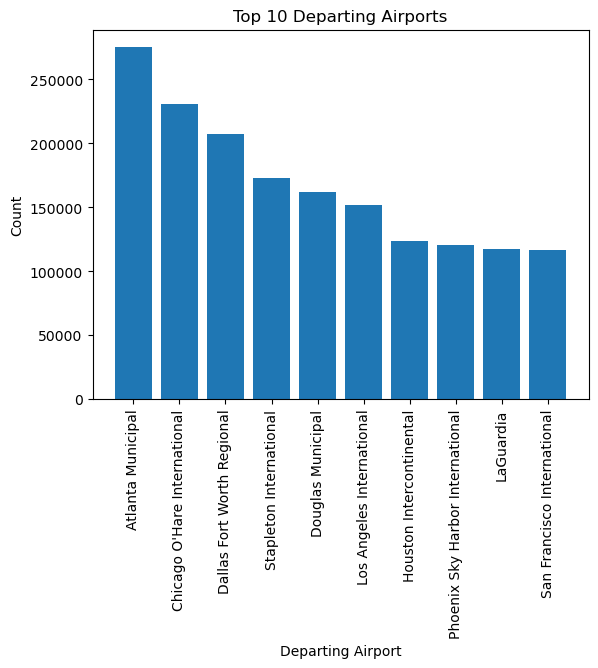

In [64]:
# Filter the top 10 departing airports
top_10_airports_sql = spark.sql("SELECT DEPARTING_AIRPORT, COUNT(*) AS count FROM flight_data GROUP BY DEPARTING_AIRPORT ORDER BY count DESC LIMIT 10")
 
# Convert the result to a Pandas DataFrame
top_10_airports_pd = top_10_airports_sql.toPandas()
 
# Plot the geographic distribution of top 10 departing airports
plt.bar(top_10_airports_pd["DEPARTING_AIRPORT"], top_10_airports_pd["count"])
plt.xlabel("Departing Airport")
plt.ylabel("Count")
plt.title("Top 10 Departing Airports")
plt.xticks(rotation=90)
plt.show()

+--------------------+-------------------+
|        CARRIER_NAME|    Delay_Frequency|
+--------------------+-------------------+
|Frontier Airlines...|0.26064493350594325|
|     JetBlue Airways| 0.2539728877612764|
|Atlantic Southeas...|0.23307933662034963|
|Southwest Airline...| 0.2090420207347565|
|American Airlines...|0.20103481354233996|
|  Mesa Airlines Inc.|0.19544821254560243|
|United Air Lines ...|0.19528367377990793|
|         Comair Inc.|  0.193988198089525|
|       Allegiant Air|0.18975498115239633|
|    Spirit Air Lines|0.18855424410979968|
|American Eagle Ai...|   0.17969324770871|
|SkyWest Airlines ...|0.17833870250240758|
|   Endeavor Air Inc.|0.17432525368777105|
|Midwest Airline, ...|0.16428116292118802|
|Alaska Airlines Inc.| 0.1639846057459948|
|Delta Air Lines Inc.|0.14638496823739616|
|Hawaiian Airlines...|0.08694988940584242|
+--------------------+-------------------+



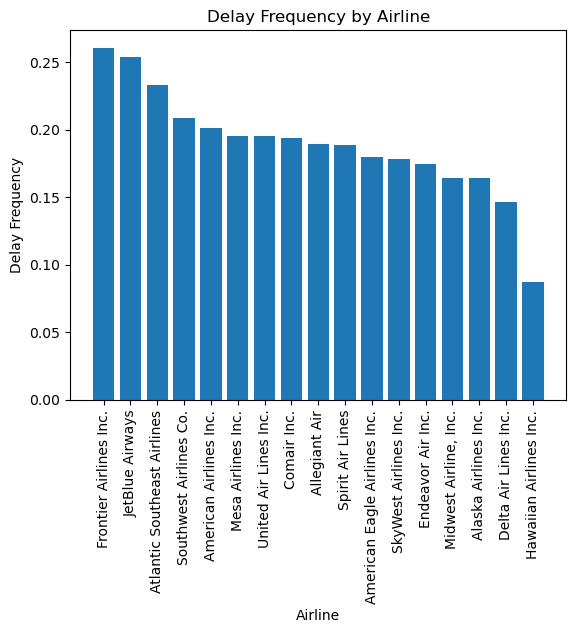

In [65]:
# Calculate the frequency of delays by airline using SQL
delay_freq_by_airline_sql = spark.sql("SELECT CARRIER_NAME, AVG(DEP_DEL15) AS Delay_Frequency FROM flight_data GROUP BY CARRIER_NAME ORDER BY Delay_Frequency DESC")
delay_freq_by_airline_sql.show()
 
# Plot the delay frequency by airline
delay_freq_by_airline_sql_pd = delay_freq_by_airline_sql.toPandas()
plt.bar(delay_freq_by_airline_sql_pd["CARRIER_NAME"], delay_freq_by_airline_sql_pd["Delay_Frequency"])
plt.xlabel("Airline")
plt.ylabel("Delay Frequency")
plt.title("Delay Frequency by Airline")
plt.xticks(rotation=90)
plt.show()

In [66]:
all_data = all_data.toPandas()

In [67]:
from sklearn.model_selection import train_test_split
# Split into subsets
train, test = train_test_split(all_data, test_size=.3, random_state=42, stratify=all_data['DEP_DEL15'])

# Our Train set
train.head()

,MONTH,DAY_OF_WEEK,DEP_DEL15,DEP_TIME_BLK,DISTANCE_GROUP,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,CARRIER_NAME,AIRPORT_FLIGHTS_MONTH,...,PREVIOUS_AIRPORT,PRCP,SNOW,SNWD,TMAX,AWND,CARRIER_HISTORICAL,DEP_AIRPORT_HIST,DAY_HISTORICAL,DEP_BLOCK_HIST
3839170,6,2,0,0900-0959,1,2,80,129,Delta Air Lines Inc.,33994,...,Indianapolis Muni/Weir Cook,0.00,0.0,0.0,87.0,8.28,0.200730,0.206545,0.232388,0.151937
3543367,9,3,0,1300-1359,5,3,16,230,Frontier Airlines Inc.,9403,...,Raleigh-Durham International,0.00,0.0,0.0,91.0,10.07,0.203524,0.129322,0.128298,0.136288
3393217,11,5,0,1600-1659,3,2,48,142,United Air Lines Inc.,26830,...,Tampa International,0.00,0.0,0.0,40.0,6.49,0.140077,0.116284,0.153722,0.176146
420677,5,7,0,0900-0959,3,2,19,143,Southwest Airlines Co.,7716,...,Sacramento International,0.00,0.0,0.0,69.0,5.82,0.248620,0.174306,0.211331,0.131481
2641761,4,1,0,2300-2359,11,2,16,291,United Air Lines Inc.,13675,...,Newark Liberty International,0.03,0.0,0.0,61.0,11.41,0.183223,0.240921,0.237972,0.166167


In [68]:
test.head()

,MONTH,DAY_OF_WEEK,DEP_DEL15,DEP_TIME_BLK,DISTANCE_GROUP,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,CARRIER_NAME,AIRPORT_FLIGHTS_MONTH,...,PREVIOUS_AIRPORT,PRCP,SNOW,SNWD,TMAX,AWND,CARRIER_HISTORICAL,DEP_AIRPORT_HIST,DAY_HISTORICAL,DEP_BLOCK_HIST
70931,10,3,0,2100-2159,1,6,19,143,Southwest Airlines Co.,8879,...,Raleigh-Durham International,1.29,0.0,0.0,65.0,7.38,0.179323,0.161464,0.157511,0.223513
264816,8,6,0,1100-1159,3,1,8,140,American Airlines Inc.,7044,...,NONE,0.00,0.0,0.0,86.0,7.83,0.228215,0.187867,0.161870,0.165124
2483682,6,3,0,1300-1359,3,2,16,175,Southwest Airlines Co.,7052,...,Seattle International,0.18,0.0,0.0,72.0,9.40,0.259775,0.187631,0.237175,0.232153
908448,6,7,0,1700-1759,2,3,14,143,Southwest Airlines Co.,8896,...,Nashville International,0.00,0.0,0.0,92.0,10.96,0.259775,0.262245,0.270709,0.345016
3044934,9,3,0,1100-1159,3,2,48,132,Delta Air Lines Inc.,9468,...,Cleveland-Hopkins International,0.00,0.0,0.0,83.0,11.18,0.101805,0.116928,0.128298,0.118393


In [69]:
# Create lookup tables 

carrier_historical = pd.DataFrame(train.groupby(['CARRIER_NAME', 'MONTH'])['DEP_DEL15'].mean().transpose().reset_index())
carrier_historical.rename(columns={'DEP_DEL15':'CARRIER_HISTORICAL'}, inplace=True)

airport_historical = pd.DataFrame(train.groupby(['DEPARTING_AIRPORT', 'MONTH'])['DEP_DEL15'].mean().transpose().reset_index())
airport_historical.rename(columns={'DEP_DEL15':'DEP_AIRPORT_HIST'}, inplace=True)

prev_airport_historical = airport_historical
prev_airport_historical.rename(columns={'DEPARTING_AIRPORT':'PREVIOUS_AIRPORT', 'DEP_DEL15':'PREV_AIRPORT_HIST'}, inplace=True)

day_historical = pd.DataFrame(train.groupby(['DAY_OF_WEEK', 'MONTH'])['DEP_DEL15'].mean().transpose().reset_index())
day_historical.rename(columns={'DEP_DEL15':'DAY_HISTORICAL'}, inplace=True)

dep_block_lookup = pd.DataFrame(train.groupby(['DEP_TIME_BLK', 'MONTH'])['DEP_DEL15'].mean().transpose().reset_index())
dep_block_lookup.rename(columns={'DEP_DEL15':'DEP_BLOCK_HIST'}, inplace=True)

In [70]:
# Merge lookup tables back onto data frame

train = pd.merge(train, carrier_historical, how='left')
train = pd.merge(train, airport_historical, how='left')
train = pd.merge(train, prev_airport_historical, how='left')
train = pd.merge(train, day_historical, how='left')
train = pd.merge(train, dep_block_lookup, how='left')

In [71]:
# Now merge these lookup tables onto our Validation data frame

test = pd.merge(test, carrier_historical, how='left')
test = pd.merge(test, airport_historical, how='left')
test = pd.merge(test, prev_airport_historical, how='left')
test = pd.merge(test, day_historical, how='left')
test = pd.merge(test, dep_block_lookup, how='left')

In [72]:
# Fillna with mean
train['DEP_AIRPORT_HIST'].fillna(train['DEP_AIRPORT_HIST'].mean(), inplace=True)

# Save DataFrame to a pickle file
train.to_pickle("train.pkl")


In [73]:
# fillna with mean
test['DEP_AIRPORT_HIST'].fillna(test['DEP_AIRPORT_HIST'].mean(), inplace=True)

# Save DataFrame to a pickle file
test.to_pickle("test.pkl")

# Save DataFrame to a CSV file
test.to_csv("test.csv", index=False)

# Visualizations


### Average Departure Delay by Carrier 
It displays the average departure delay (in minutes) for each carrier in the dataset.

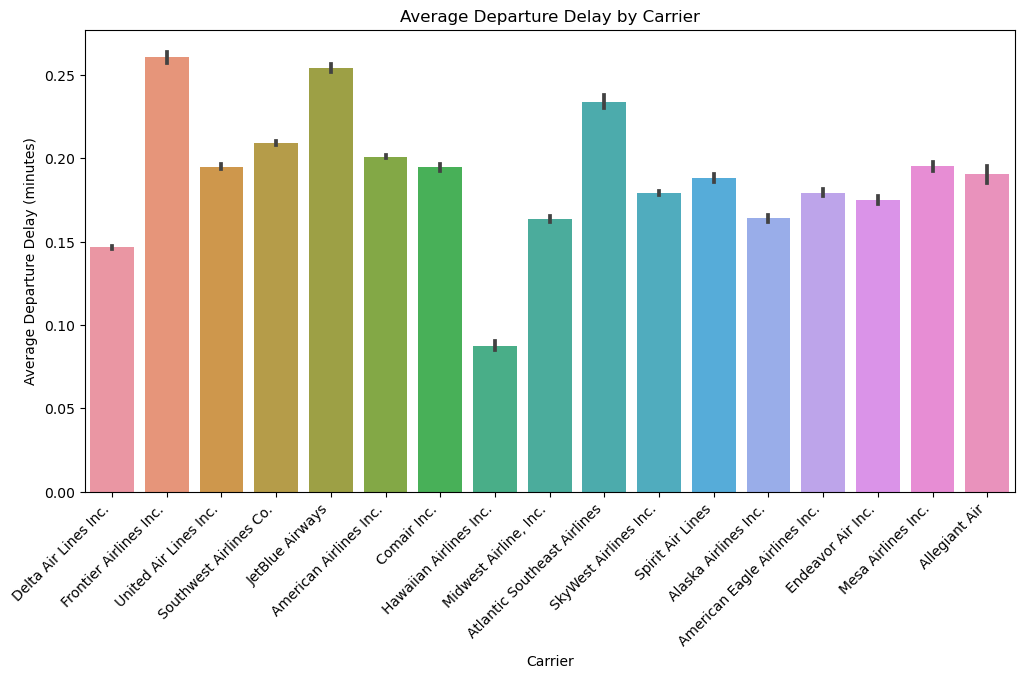

In [75]:
# Visualization 1: Carrier Performance

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.barplot(data=train, x='CARRIER_NAME', y='DEP_DEL15')
plt.title('Average Departure Delay by Carrier')
plt.xlabel('Carrier')
plt.ylabel('Average Departure Delay (minutes)')
plt.xticks(rotation=45, ha='right')
plt.show()

It offers insights into the relative performance of different carriers in terms of departure punctuality, helping identify which carriers experience longer delays on average and informing decisions related to carrier selection for travelers or operational considerations for airlines.

## Airline Departure Delay Analysis

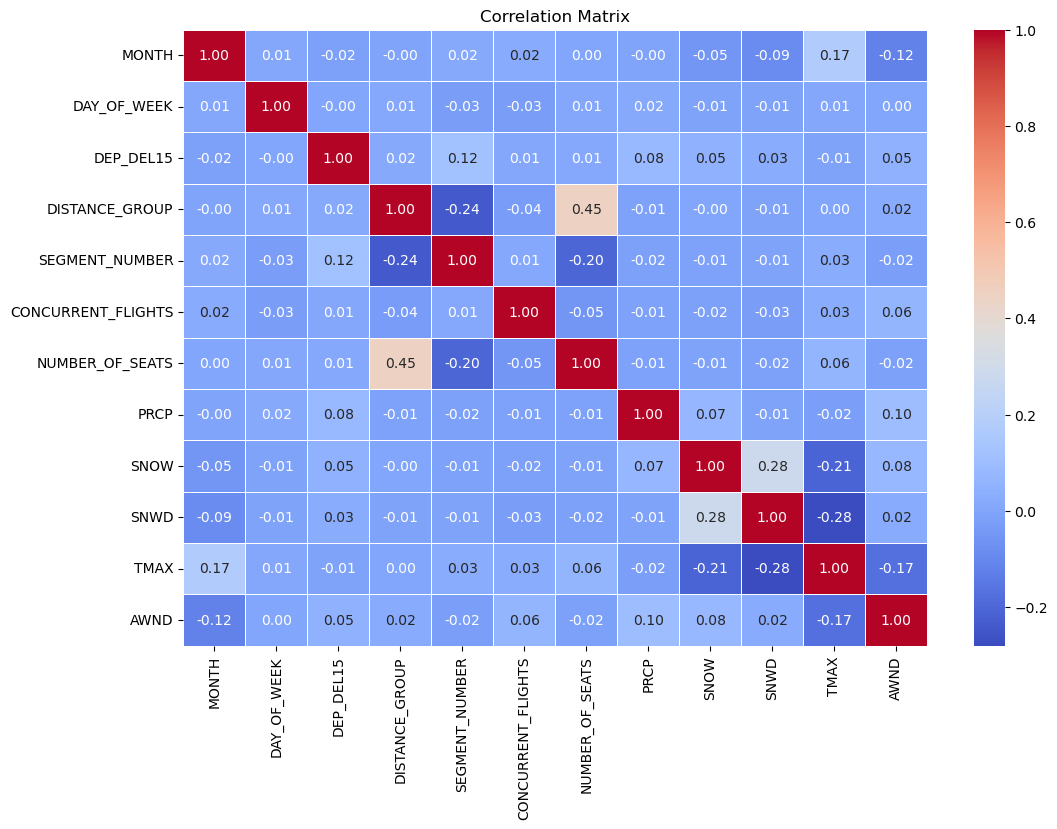

In [76]:

 
# Select relevant columns for correlation analysis
selected_columns = ['MONTH', 'DAY_OF_WEEK', 'DEP_DEL15', 'DISTANCE_GROUP', 'SEGMENT_NUMBER', 
                    'CONCURRENT_FLIGHTS', 'NUMBER_OF_SEATS', 'PRCP', 'SNOW', 'SNWD', 'TMAX', 'AWND']
 
# Subset the DataFrame with the selected columns
selected_data = train[selected_columns]
 
# Compute the correlation matrix
correlation_matrix = selected_data.corr()
 
# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

This heatmap visualization, titled "Correlation Matrix," illustrates the pairwise correlations between different variables in the dataset. By representing correlations with color intensity and providing numerical annotations, it facilitates the identification of relationships between variables. Insights gained can include understanding which factors may influence departure delays the most and potential multicollinearity issues when building predictive models.